In [ ]:
!pip install sktime

In [ ]:
!pip install eli5

In [ ]:
!pip install joblib

In [ ]:
!pip install shap

In [ ]:
# 건물별 피쳐중요도 관련
from eli5.lightgbm import *
from eli5.sklearn import *
import eli5
import joblib
import shap
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

DATA_PATH = "/content/drive/MyDrive/project/data/"
SEED = 42

In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from lightgbm import early_stopping
import xgboost as xgb

In [ ]:
def _smape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    v = 2 * np.abs(pred - true) / (np.abs(pred) + np.abs(true))
    output = np.mean(v) * 100
    return output
smape = make_scorer(_smape, greater_is_better=False)

In [ ]:
def lightgbm_smape(y_true, y_pred):
    smape_val = _smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED) # Seed 고정

# 피쳐 불러오기

In [ ]:
train_df = pd.read_csv(f"{DATA_PATH}train_ver5-21.csv")
test_df = pd.read_csv(f"{DATA_PATH}test_ver5-21.csv")

In [ ]:
train_df.head()

,power,building_num,date_time,temp,pred,wind,hum,sunshine,solar_rad,type,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1034.40,1,20220602 00,0.296296,0.0,0.030075,0.5875,0.0,0.0,건물기타,...,0.486146,28.818026,0.561375,1627.80,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,973.92,1,20220602 01,0.277778,0.0,0.060150,0.6125,0.0,0.0,건물기타,...,0.463720,27.987268,0.569652,1550.08,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,909.12,1,20220602 02,0.262963,0.0,0.052632,0.6375,0.0,0.0,건물기타,...,0.438531,27.080175,0.570591,1431.12,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,893.28,1,20220602 03,0.262963,0.0,0.165414,0.6875,0.0,0.0,건물기타,...,0.411929,26.152269,0.563922,1372.20,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,924.00,1,20220602 04,0.262963,0.0,0.150376,0.7625,0.0,0.0,건물기타,...,0.384706,25.248724,0.550685,1381.72,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
test_df.head()

,building_num,date_time,temp,pred,wind,hum,type,time,day,month,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1,20220825 00,0.562189,0.0,0.314286,0.621622,건물기타,0,3,8,...,0.699765,31.683443,0.751924,1627.80,0.031576,0.120989,0.040900,0.040900,76.039531,45.466667
1,1,20220825 01,0.537313,0.0,0.128571,0.621622,건물기타,1,3,8,...,0.681421,31.240887,0.747316,1550.08,0.031339,0.113930,0.041816,0.041816,75.744150,45.733333
2,1,20220825 02,0.522388,0.0,0.214286,0.662162,건물기타,2,3,8,...,0.664463,30.821889,0.740550,1431.12,0.032710,0.102097,0.043848,0.043848,75.382650,46.091667
3,1,20220825 03,0.492537,0.0,0.185714,0.702703,건물기타,3,3,8,...,0.646699,30.391003,0.731578,1372.20,0.034079,0.080509,0.047393,0.047393,74.931834,46.445833
4,1,20220825 04,0.477612,0.0,0.142857,0.689189,건물기타,4,3,8,...,0.628614,29.958487,0.720400,1381.72,0.033533,0.063424,0.049559,0.049559,74.436733,46.800000


### 피쳐 드랍

In [ ]:
# 기본

train_df = train_df.drop(columns=['temp', 'pred', 'wind', 'hum', 'sunshine', 'solar_rad', 'type', 'heat_wave', 'heat_index', 'CDH', 'hour_std', 'hour_mean'])
test_df = test_df.drop(columns=['temp', 'pred', 'wind', 'hum', 'type', 'heat_wave', 'heat_index', 'CDH', 'hour_std', 'hour_mean'])

In [ ]:
train_df

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1034.40,1,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1627.800000,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,973.92,1,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1550.080000,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,909.12,1,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1431.120000,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,893.28,1,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1372.200000,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,924.00,1,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1381.720000,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201595,881.04,100,0.0,19,2,8,34,236,-0.965926,0.258819,...,0.614245,30.510262,0.493750,964.873846,0.009927,0.126797,0.020113,0.020113,76.873895,51.933333
201596,798.96,100,0.0,20,2,8,34,236,-0.866025,0.500000,...,0.610794,30.441848,0.502798,882.184615,0.012024,0.159450,0.018409,0.018409,76.988270,51.741667
201597,825.12,100,0.0,21,2,8,34,236,-0.707107,0.707107,...,0.603461,30.233938,0.511343,779.095385,0.020125,0.197957,0.016808,0.016808,76.987238,51.862500
201598,640.08,100,0.0,22,2,8,34,236,-0.500000,0.866025,...,0.594174,29.960151,0.518515,663.267692,0.021549,0.215927,0.017735,0.017735,76.862771,52.120833


In [ ]:
train_df.shape , test_df.shape

((201600, 30), (16800, 29))

In [ ]:
# 자동 변수 생성
for i in range(1, 101):
    globals()[f'train_df_{i}'] = train_df[train_df['building_num'] == i].reset_index(drop=True)
    globals()[f'test_df_{i}'] = test_df[test_df['building_num'] == i].reset_index(drop=True)

In [ ]:
# 변수 리스트 생성
train_list = []
test_list = []
for i in globals():
    if i.startswith('train_df_'):
        train_list.append(i)
    elif i.startswith('test_df_'):
        test_list.append(i)
    else:
        pass

In [ ]:
len(train_list) , len(test_list)

(100, 100)

In [ ]:
# 데이터셋 만들기(마지막 7일간의 데이터를 검증데이터셋으로 사용)
def make_dataset(train_df, test_df):
    train_x = train_df.iloc[:, 2:]
    train_y = train_df['power']

    test_x = test_df.iloc[:, 1:]
    return train_x, train_y, test_x

def train_test_split(train_x, train_y, test_size=168):
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = test_size)
    return x_train, y_train, x_valid, y_valid


In [ ]:
# n_fold로 데이터셋 나누기
def n_fold_train_test_split(train_x, train_y, n, test_size=168, week=11):
    x_valid = train_x[test_size * (week-n-1):test_size * (week-n)]
    y_valid = train_y[test_size * (week-n-1):test_size * (week-n)]
    x_train = train_x.drop(index = list(x_valid.index))
    y_train = train_y.drop(index = list(y_valid.index))
    return x_train, y_train, x_valid, y_valid

In [ ]:
def train_test_split(train_x, train_y, test_size=168):
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = test_size)
    return x_train, y_train, x_valid, y_valid

In [ ]:
# LGBMRegressor 모델
def lgbm_predict(model, x_train, y_train, x_valid, y_valid, stopping=300, eval_metric=lightgbm_smape):
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(stopping)], eval_metric=eval_metric)
    pred = model.predict(x_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
    smape_score = _smape(y_valid, pred)
    print(f"SMAPE_SCORE : {smape_score}")
    return smape_score

# test dataset 예측
def lgbm_test_predict(model, train_x, train_y, test_x):
    model.fit(train_x, train_y)
    lgbm_pred = model.predict(test_x)
    return lgbm_pred

In [ ]:
# XGBoost 모델
def xgb_smape(preds, dtrain):
    labels = dtrain.get_label()
    return 'xgb_smape', np.mean((np.abs(labels-preds))/(np.abs(labels) + np.abs(preds)))*100

def xgb_predict(model, x_train, y_train, x_valid, y_valid, stopping=300, eval_metric=xgb_smape):
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], early_stopping_rounds=stopping, eval_metric=xgb_smape)
    pred = model.predict(x_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    fig, ax = plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
    smape_score = _smape(y_valid, pred)
    print(f"SMAPE_SCORE : {smape_score}")
    return smape_score

def xgb_test_predict(model, train_x, train_y, test_x):
    model.fit(train_x, train_y)
    xgb_pred = model.predict(test_x)
    return xgb_pred

# 건물별



---
### 1번 건물


In [ ]:
train_df_1

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1034.40,1,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1627.800000,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,973.92,1,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1550.080000,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,909.12,1,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1431.120000,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,893.28,1,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1372.200000,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,924.00,1,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1381.720000,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2517.12,1,0.0,19,2,8,34,236,-0.965926,0.258819,...,0.648937,32.426683,0.565397,2571.470769,0.018130,0.056167,0.031224,0.031224,76.057339,44.795833
2012,2208.96,1,0.0,20,2,8,34,236,-0.866025,0.500000,...,0.653348,32.548721,0.578365,2391.027692,0.020859,0.076994,0.028379,0.028379,76.250510,44.845833
2013,1806.24,1,0.0,21,2,8,34,236,-0.707107,0.707107,...,0.653282,32.541195,0.591468,1887.950769,0.023743,0.087830,0.027473,0.027473,76.319618,44.883333
2014,1387.20,1,0.0,22,2,8,34,236,-0.500000,0.866025,...,0.647782,32.361014,0.603331,1412.861538,0.022213,0.103387,0.024673,0.024673,76.276394,45.012500


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_1['weekend'] = train_df_1['day'].isin([6]) + 0
test_df_1['weekend'] = test_df_1['day'].isin([6]) + 0

In [ ]:
# day_of_year, time 삭제
train_df_1 = train_df_1.drop(columns=['day_of_year','time'])
test_df_1 = test_df_1.drop(columns=['day_of_year','time'])

In [ ]:
train_df_1

,power,building_num,pred,day,month,week,sin_time,cos_time,temp_RM,wind_RM,...,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean,weekend
0,1034.40,1,0.0,3,6,22,0.000000,1.000000,0.544101,0.264177,...,28.818026,0.561375,1627.800000,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333,0
1,973.92,1,0.0,3,6,22,0.258819,0.965926,0.504280,0.240664,...,27.987268,0.569652,1550.080000,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833,0
2,909.12,1,0.0,3,6,22,0.500000,0.866025,0.462598,0.214385,...,27.080175,0.570591,1431.120000,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833,0
3,893.28,1,0.0,3,6,22,0.707107,0.707107,0.421288,0.199170,...,26.152269,0.563922,1372.200000,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667,0
4,924.00,1,0.0,3,6,22,0.866025,0.500000,0.382583,0.177040,...,25.248724,0.550685,1381.720000,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2517.12,1,0.0,2,8,34,-0.965926,0.258819,0.638258,0.227524,...,32.426683,0.565397,2571.470769,0.018130,0.056167,0.031224,0.031224,76.057339,44.795833,0
2012,2208.96,1,0.0,2,8,34,-0.866025,0.500000,0.642724,0.218534,...,32.548721,0.578365,2391.027692,0.020859,0.076994,0.028379,0.028379,76.250510,44.845833,0
2013,1806.24,1,0.0,2,8,34,-0.707107,0.707107,0.642352,0.201936,...,32.541195,0.591468,1887.950769,0.023743,0.087830,0.027473,0.027473,76.319618,44.883333,0
2014,1387.20,1,0.0,2,8,34,-0.500000,0.866025,0.635281,0.187414,...,32.361014,0.603331,1412.861538,0.022213,0.103387,0.024673,0.024673,76.276394,45.012500,0


In [ ]:
test_df_1

,building_num,pred,day,month,week,sin_time,cos_time,temp_RM,wind_RM,hum_RM,...,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean,weekend
0,1,0.0,3,8,34,0.000000,1.000000,0.717293,0.416382,0.457627,...,31.683443,0.751924,1627.800000,0.031576,0.120989,0.040900,0.040900,76.039531,45.466667,0
1,1,0.0,3,8,34,0.258819,0.965926,0.694236,0.382253,0.471969,...,31.240887,0.747316,1550.080000,0.031339,0.113930,0.041816,0.041816,75.744150,45.733333,0
2,1,0.0,3,8,34,0.500000,0.866025,0.672180,0.383959,0.488918,...,30.821889,0.740550,1431.120000,0.032710,0.102097,0.043848,0.043848,75.382650,46.091667,0
3,1,0.0,3,8,34,0.707107,0.707107,0.649624,0.372014,0.505867,...,30.391003,0.731578,1372.200000,0.034079,0.080509,0.047393,0.047393,74.931834,46.445833,0
4,1,0.0,3,8,34,0.866025,0.500000,0.627068,0.348123,0.522816,...,29.958487,0.720400,1381.720000,0.033533,0.063424,0.049559,0.049559,74.436733,46.800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,0.0,2,8,35,-0.965926,0.258819,0.558396,0.465870,0.667536,...,28.755235,0.407707,2571.470769,0.018130,0.056167,0.031224,0.031224,76.057339,50.854167,0
164,1,0.0,2,8,35,-0.866025,0.500000,0.570927,0.470990,0.651890,...,28.993116,0.428053,2391.027692,0.020859,0.076994,0.028379,0.028379,76.250510,50.458333,0
165,1,0.0,2,8,35,-0.707107,0.707107,0.577945,0.470990,0.638853,...,29.120443,0.448742,1887.950769,0.023743,0.087830,0.027473,0.027473,76.319618,50.100000,0
166,1,0.0,2,8,35,-0.500000,0.866025,0.575940,0.465870,0.637549,...,29.077596,0.468353,1412.861538,0.022213,0.103387,0.024673,0.024673,76.276394,50.041667,0




---
### 2번 건물


In [ ]:
train_df_2.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1131.84,2,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1242.45,0.031366,0.125030,0.039856,0.039856,76.045965,31.908333
1,1127.16,2,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1236.18,0.031167,0.116703,0.041058,0.041058,75.757098,33.420833
2,1118.16,2,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1227.81,0.032591,0.103428,0.043448,0.043448,75.398080,35.120833
3,1070.64,2,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1205.67,0.033639,0.084309,0.046259,0.046259,74.962466,36.991667
4,1067.76,2,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1196.07,0.032716,0.068891,0.047808,0.047808,74.491000,38.766667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_2['weekend'] = train_df_2['day'].isin([0]) + 0
test_df_2['weekend'] = test_df_2['day'].isin([0]) + 0

In [ ]:
train_df_2 = train_df_2.drop(columns=['day_of_year', 'time'])
test_df_2 = test_df_2.drop(columns=['day_of_year', 'time'])



---
### 3번 건물


In [ ]:
train_df_3.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,857.52,3,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,980.445,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,825.48,3,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,939.060,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,821.52,3,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,913.440,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,817.56,3,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,879.000,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,772.56,3,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,847.305,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_3['weekend'] = train_df_3['day'].isin([0]) + 0
test_df_3['weekend'] = test_df_3['day'].isin([0]) + 0

In [ ]:
train_df_3 = train_df_3.drop(columns=['day_of_year', 'time'])
test_df_3 = test_df_3.drop(columns=['day_of_year', 'time'])



---

### 4번 건물

In [ ]:
train_df_4.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,690.48,4,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,710.985,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,658.44,4,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,711.480,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,655.38,4,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,719.250,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,660.60,4,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,719.115,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,683.46,4,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,719.715,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_4 = train_df_4.drop(columns=['day_of_year', 'time'])
test_df_4 = test_df_4.drop(columns=['day_of_year', 'time'])



---
### 5번 건물


In [ ]:
train_df_5.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1565.28,5,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1788.63,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,1595.52,5,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1793.88,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,1581.84,5,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1794.48,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,1584.72,5,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1802.13,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1610.64,5,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1817.55,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_5['weekend'] = train_df_5['day'].isin([0, 1, 2, 3]) + 0
test_df_5['weekend'] = test_df_5['day'].isin([0, 1, 2, 3]) + 0

In [ ]:
train_df_5 = train_df_5.drop(columns=['day_of_year', 'time'])
test_df_5 = test_df_5.drop(columns=['day_of_year', 'time'])



---
### 6번 건물


In [ ]:
train_df_6.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,971.52,6,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,1170.68,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,899.52,6,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,1017.88,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,879.84,6,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,984.52,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,860.64,6,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,978.92,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,842.88,6,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,961.32,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_6['weekend'] = 0
test_df_6['weekend'] = 0

mask_train = (train_df_6['day_of_year'] == 163) | (train_df_6['day_of_year'] == 177)| (train_df_6['day_of_year'] == 191)| (train_df_6['day_of_year'] == 205)| (train_df_6['day_of_year'] == 226)
train_df_6.loc[mask_train, 'weekend'] = 1

mask_test = test_df_6['day_of_year'] == 240
test_df_6.loc[mask_test, 'weekend'] = 1


In [ ]:
train_df_6 = train_df_6.drop(columns=['day_of_year', 'time'])
test_df_6 = test_df_6.drop(columns=['day_of_year', 'time'])



---
### 7번 건물


In [ ]:
train_df_7.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,552.72,7,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,441.34,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,548.64,7,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,432.90,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,522.96,7,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,430.98,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,518.88,7,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,419.94,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,536.16,7,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,419.94,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_7['weekend'] = train_df_7['day'].isin([5, 6]) + 0

test_df_7['weekend'] = test_df_7['day'].isin([5, 6]) + 0

In [ ]:
train_df_7 = train_df_7.drop(columns=['day_of_year', 'time'])
test_df_7 = test_df_7.drop(columns=['day_of_year', 'time'])



---
### 8번 건물


In [ ]:
train_df_8.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1181.76,8,0.0,0,3,6,22,153,0.000000,1.000000,...,0.482434,28.889247,0.546429,1364.62,0.032856,0.219781,0.043469,0.043469,75.317578,27.666667
1,1101.84,8,0.0,1,3,6,22,153,0.258819,0.965926,...,0.454007,27.895616,0.567072,1269.64,0.036342,0.234890,0.045113,0.045113,74.964167,28.779167
2,1086.72,8,0.0,2,3,6,22,153,0.500000,0.866025,...,0.420445,26.736158,0.577293,1230.26,0.041798,0.251608,0.047141,0.047141,74.468340,30.162500
3,1144.56,8,0.0,3,3,6,22,153,0.707107,0.707107,...,0.375174,25.226360,0.575182,1303.24,0.058265,0.276738,0.051606,0.051606,73.858379,31.666667
4,1200.48,8,0.0,4,3,6,22,153,0.866025,0.500000,...,0.329928,23.773978,0.561208,1378.42,0.050465,0.252063,0.057082,0.057082,73.239702,33.183333


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_8['weekend'] = train_df_8['day'].isin([6]) + 0

test_df_8['weekend'] = test_df_8['day'].isin([6]) + 0

In [ ]:
train_df_8 = train_df_8.drop(columns=['day_of_year', 'time'])
test_df_8 = test_df_8.drop(columns=['day_of_year', 'time'])



---
### 9번 건물


In [ ]:
train_df_9.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1280.16,9,0.0,0,3,6,22,153,0.000000,1.000000,...,0.536988,30.203506,0.630173,1506.64,0.023756,0.193821,0.032316,0.032316,76.733478,35.183333
1,1060.80,9,0.0,1,3,6,22,153,0.258819,0.965926,...,0.511189,29.202712,0.635300,1289.76,0.026399,0.183938,0.032420,0.032420,76.355220,37.045833
2,996.48,9,0.0,2,3,6,22,153,0.500000,0.866025,...,0.482907,28.170186,0.632217,1199.44,0.027295,0.166965,0.036850,0.036850,75.947537,38.875000
3,959.52,9,0.0,3,3,6,22,153,0.707107,0.707107,...,0.451285,27.071542,0.621092,1161.20,0.029435,0.150973,0.038290,0.038290,75.496817,40.895833
4,963.84,9,0.0,4,3,6,22,153,0.866025,0.500000,...,0.416489,25.943193,0.601924,1156.40,0.031061,0.133493,0.041537,0.041537,75.040734,42.837500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_9['weekend'] = 0
test_df_9['weekend'] = 0

mask_train = (train_df_9['day_of_year'] == 163) | (train_df_9['day_of_year'] == 177)| (train_df_9['day_of_year'] == 191)| (train_df_9['day_of_year'] == 205)| (train_df_9['day_of_year'] == 226)
train_df_9.loc[mask_train, 'weekend'] = 1

mask_test = test_df_9['day_of_year'] == 240
test_df_9.loc[mask_test, 'weekend'] = 1


In [ ]:
train_df_9 = train_df_9.drop(columns=['day_of_year', 'time'])
test_df_9 = test_df_9.drop(columns=['day_of_year', 'time'])



---
### 10번 건물


In [ ]:
train_df_10.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,4047.84,10,0.0,0,3,6,22,153,0.000000,1.000000,...,0.459593,27.485836,0.499246,4296.20,0.023211,0.178991,0.030204,0.030204,74.785017,38.633333
1,3996.00,10,0.0,1,3,6,22,153,0.258819,0.965926,...,0.448951,27.050955,0.498978,4289.04,0.022565,0.161344,0.030860,0.030860,74.547432,40.237500
2,3995.04,10,0.0,2,3,6,22,153,0.500000,0.866025,...,0.436178,26.557665,0.494621,4219.12,0.023427,0.143317,0.033086,0.033086,74.298527,41.987500
3,4024.32,10,0.0,3,3,6,22,153,0.707107,0.707107,...,0.420591,25.994202,0.486277,4193.12,0.023613,0.126781,0.036120,0.036120,74.006040,43.879167
4,4025.76,10,0.0,4,3,6,22,153,0.866025,0.500000,...,0.406373,25.516118,0.474951,4190.40,0.024966,0.115078,0.037856,0.037856,73.728041,45.320833


In [ ]:
train_df_10 = train_df_10.drop(columns=['day_of_year', 'time'])
test_df_10 = test_df_10.drop(columns=['day_of_year', 'time'])



---
### 11번 건물


In [ ]:
train_df_11.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1460.40,11,0.0,0,3,6,22,153,0.000000,1.000000,...,0.482434,28.889247,0.546429,1726.74,0.032856,0.219781,0.043469,0.043469,75.317578,27.666667
1,1519.68,11,0.0,1,3,6,22,153,0.258819,0.965926,...,0.454007,27.895616,0.567072,1793.50,0.036342,0.234890,0.045113,0.045113,74.964167,28.779167
2,1390.80,11,0.0,2,3,6,22,153,0.500000,0.866025,...,0.420445,26.736158,0.577293,1650.44,0.041798,0.251608,0.047141,0.047141,74.468340,30.162500
3,1324.08,11,0.0,3,3,6,22,153,0.707107,0.707107,...,0.375174,25.226360,0.575182,1625.72,0.058265,0.276738,0.051606,0.051606,73.858379,31.666667
4,1316.40,11,0.0,4,3,6,22,153,0.866025,0.500000,...,0.329928,23.773978,0.561208,1615.28,0.050465,0.252063,0.057082,0.057082,73.239702,33.183333


In [ ]:
train_df_11 = train_df_11.drop(columns=['day_of_year', 'time'])
test_df_11 = test_df_11.drop(columns=['day_of_year', 'time'])



---
### 12번 건물


In [ ]:
train_df_12.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,948.60,12,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,1149.975,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,949.32,12,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,1163.805,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,925.92,12,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,1139.760,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,980.10,12,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,1164.495,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,1016.64,12,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,1224.870,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_12['weekend'] = train_df_12['day'].isin([6]) + 0

test_df_12['weekend'] = test_df_12['day'].isin([6]) + 0

In [ ]:
train_df_12 = train_df_12.drop(columns=['day_of_year', 'time'])
test_df_12 = test_df_12.drop(columns=['day_of_year', 'time'])



---
### 13번 건물


In [ ]:
train_df_13.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2556.96,13,0.0,0,3,6,22,153,0.000000,1.000000,...,0.459593,27.485836,0.499246,2740.04,0.023211,0.178991,0.030204,0.030204,74.785017,38.633333
1,2388.48,13,0.0,1,3,6,22,153,0.258819,0.965926,...,0.448951,27.050955,0.498978,2697.44,0.022565,0.161344,0.030860,0.030860,74.547432,40.237500
2,2425.92,13,0.0,2,3,6,22,153,0.500000,0.866025,...,0.436178,26.557665,0.494621,2680.92,0.023427,0.143317,0.033086,0.033086,74.298527,41.987500
3,2480.64,13,0.0,3,3,6,22,153,0.707107,0.707107,...,0.420591,25.994202,0.486277,2692.60,0.023613,0.126781,0.036120,0.036120,74.006040,43.879167
4,2553.60,13,0.0,4,3,6,22,153,0.866025,0.500000,...,0.406373,25.516118,0.474951,2691.96,0.024966,0.115078,0.037856,0.037856,73.728041,45.320833


In [ ]:
train_df_13 = train_df_13.drop(columns=['day_of_year', 'time'])
test_df_13 = test_df_13.drop(columns=['day_of_year', 'time'])



---
### 14번 건물


In [ ]:
train_df_14.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1389.12,14,0.0,0,3,6,22,153,0.000000,1.000000,...,0.397299,25.771732,0.440334,1700.72,0.037275,0.085029,0.049247,0.049247,73.989059,35.704167
1,2145.60,14,0.0,1,3,6,22,153,0.258819,0.965926,...,0.381698,25.205370,0.441674,2110.24,0.040031,0.061765,0.051017,0.051017,73.754898,37.775000
2,2198.88,14,0.0,2,3,6,22,153,0.500000,0.866025,...,0.361252,24.518526,0.437854,2219.20,0.042180,0.037873,0.055025,0.055025,73.423421,39.850000
3,1927.20,14,0.0,3,3,6,22,153,0.707107,0.707107,...,0.342137,23.896773,0.429342,2131.08,0.039785,0.018317,0.056832,0.056832,73.042809,41.962500
4,1958.88,14,0.0,4,3,6,22,153,0.866025,0.500000,...,0.322446,23.289660,0.416608,2073.40,0.041488,0.007725,0.058927,0.058927,72.618650,43.966667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_14['weekend'] = train_df_14['day'].isin([5,6]) + 0

test_df_14['weekend'] = test_df_14['day'].isin([5,6]) + 0

In [ ]:
train_df_14 = train_df_14.drop(columns=['day_of_year', 'time'])
test_df_14 = test_df_14.drop(columns=['day_of_year', 'time'])



---
### 15번 건물


In [ ]:
train_df_15.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1608.12,15,0.0,0,3,6,22,153,0.000000,1.000000,...,0.588910,32.458499,0.668476,1961.05125,0.023949,0.186117,0.044081,0.044081,77.624063,29.887500
1,1741.50,15,0.0,1,3,6,22,153,0.258819,0.965926,...,0.573655,31.861595,0.687008,1974.92625,0.023348,0.189895,0.045144,0.045144,77.221445,30.704167
2,1707.84,15,0.0,2,3,6,22,153,0.500000,0.866025,...,0.552864,31.045370,0.698100,2057.32500,0.026777,0.202186,0.044831,0.044831,76.729274,31.908333
3,1632.69,15,0.0,3,3,6,22,153,0.707107,0.707107,...,0.525450,30.021512,0.700647,1985.55750,0.027837,0.208863,0.046564,0.046564,76.149265,33.125000
4,1515.60,15,0.0,4,3,6,22,153,0.866025,0.500000,...,0.494890,28.914779,0.694414,1836.85875,0.033885,0.224064,0.044342,0.044342,75.504949,34.445833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_15['weekend'] = train_df_15['day'].isin([5,6]) + 0

test_df_15['weekend'] = test_df_15['day'].isin([5,6]) + 0

In [ ]:
train_df_15 = train_df_15.drop(columns=['day_of_year', 'time'])
test_df_15 = test_df_15.drop(columns=['day_of_year', 'time'])



---
### 16번 건물


In [ ]:
train_df_16.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1137.12,16,0.0,0,3,6,22,153,0.000000,1.000000,...,0.485185,28.306381,0.546496,1272.02,0.027684,0.179173,0.036228,0.036228,75.869223,38.083333
1,1102.56,16,0.0,1,3,6,22,153,0.258819,0.965926,...,0.457090,27.383540,0.548172,1252.84,0.027951,0.169617,0.040669,0.040669,75.472756,38.995833
2,1088.16,16,0.0,2,3,6,22,153,0.500000,0.866025,...,0.432090,26.550947,0.543447,1248.38,0.027111,0.153545,0.043242,0.043242,75.034768,40.316667
3,1105.92,16,0.0,3,3,6,22,153,0.707107,0.707107,...,0.406211,25.721637,0.532723,1244.52,0.027664,0.141664,0.045001,0.045001,74.594201,41.645833
4,1200.96,16,0.0,4,3,6,22,153,0.866025,0.500000,...,0.378990,24.885793,0.516035,1417.90,0.030362,0.133230,0.048654,0.048654,74.168500,42.937500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_16['weekend'] = train_df_16['day'].isin([5, 6]) + 0

test_df_16['weekend'] = test_df_16['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_16['day_of_year'] == 157) | (train_df_16['day_of_year'] == 227)
train_df_16.loc[mask, 'weekend'] = 1

In [ ]:
train_df_16 = train_df_16.drop(columns=['day_of_year', 'time'])
test_df_16 = test_df_16.drop(columns=['day_of_year', 'time'])



---
### 17번 건물

In [ ]:
train_df_17.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,514.98,17,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,631.740,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,514.44,17,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,608.100,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,521.82,17,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,610.470,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,526.32,17,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,612.750,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,519.84,17,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,731.385,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_17['weekend'] = train_df_17['day'].isin([5, 6]) + 0

test_df_17['weekend'] = test_df_17['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_17['day_of_year'] == 157) | (train_df_17['day_of_year'] == 227)
train_df_17.loc[mask, 'weekend'] = 1

In [ ]:
train_df_17 = train_df_17.drop(columns=['day_of_year', 'time'])
test_df_17 = test_df_17.drop(columns=['day_of_year', 'time'])



---
### 18번 건물


In [ ]:
train_df_18.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,780.0,18,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,914.575,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,785.4,18,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,912.725,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,787.8,18,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,907.900,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,762.6,18,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,905.550,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,774.9,18,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,912.025,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_18['weekend'] = train_df_18['day'].isin([5, 6]) + 0

test_df_18['weekend'] = test_df_18['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_18['day_of_year'] == 157) | (train_df_18['day_of_year'] == 227)
train_df_18.loc[mask, 'weekend'] = 1

In [ ]:
train_df_18 = train_df_18.drop(columns=['day_of_year', 'time'])
test_df_18 = test_df_18.drop(columns=['day_of_year', 'time'])



---
### 19번 건물


In [ ]:
train_df_19.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,560.16,19,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,710.040,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,551.16,19,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,702.525,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,556.92,19,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,701.730,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,552.96,19,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,682.560,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,574.92,19,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,685.185,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_19['weekend'] = train_df_19['day'].isin([5, 6]) + 0

test_df_19['weekend'] = test_df_19['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_19['day_of_year'] == 157) | (train_df_19['day_of_year'] == 227)
train_df_19.loc[mask, 'weekend'] = 1

In [ ]:
train_df_19 = train_df_19.drop(columns=['day_of_year', 'time'])
test_df_19 = test_df_19.drop(columns=['day_of_year', 'time'])



---
### 20번 건물


In [ ]:
train_df_20.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,916.80,20,0.0,0,3,6,22,153,0.000000,1.000000,...,0.461174,28.143854,0.573406,1006.56,0.029654,0.243263,0.035722,0.035722,75.878049,25.195833
1,908.64,20,0.0,1,3,6,22,153,0.258819,0.965926,...,0.436763,27.334926,0.587145,995.72,0.031959,0.243144,0.037908,0.037908,75.520959,26.500000
2,903.84,20,0.0,2,3,6,22,153,0.500000,0.866025,...,0.403144,26.201676,0.590798,989.28,0.043635,0.262854,0.039989,0.039989,75.029253,28.016667
3,904.32,20,0.0,3,3,6,22,153,0.707107,0.707107,...,0.370048,25.097043,0.584833,993.28,0.033513,0.242189,0.042891,0.042891,74.479873,29.587500
4,898.56,20,0.0,4,3,6,22,153,0.866025,0.500000,...,0.325879,23.665984,0.568044,988.60,0.049196,0.253208,0.050788,0.050788,73.874456,31.412500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_20['weekend'] = train_df_20['day'].isin([5, 6]) + 0

test_df_20['weekend'] = test_df_20['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_20['day_of_year'] == 157) | (train_df_20['day_of_year'] == 227)
train_df_20.loc[mask, 'weekend'] = 1

In [ ]:
train_df_20 = train_df_20.drop(columns=['day_of_year', 'time'])
test_df_20 = test_df_20.drop(columns=['day_of_year', 'time'])



---
### 21번 건물


In [ ]:
train_df_21.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1578.105,21,0.0,0,3,6,22,153,0.000000,1.000000,...,0.453772,27.863489,0.525787,1668.975000,0.027182,0.194520,0.033868,0.033868,74.207005,24.591667
1,1573.755,21,0.0,1,3,6,22,153,0.258819,0.965926,...,0.432574,27.166754,0.545022,1664.003750,0.030356,0.205622,0.033910,0.033910,73.890202,25.291667
2,1574.965,21,0.0,2,3,6,22,153,0.500000,0.866025,...,0.405497,26.265826,0.556047,1657.124583,0.035611,0.222080,0.035214,0.035214,73.511881,26.037500
3,1197.440,21,0.0,3,3,6,22,153,0.707107,0.707107,...,0.373933,25.221246,0.557656,1565.286250,0.037498,0.237421,0.036788,0.036788,73.053247,26.975000
4,1213.360,21,0.0,4,3,6,22,153,0.866025,0.500000,...,0.340628,24.134984,0.549747,1419.059167,0.044216,0.233945,0.042572,0.042572,72.585874,28.154167


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_21['weekend'] = train_df_21['day'].isin([5, 6]) + 0

test_df_21['weekend'] = test_df_21['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_21['day_of_year'] == 157) | (train_df_21['day_of_year'] == 227)
train_df_21.loc[mask, 'weekend'] = 1

In [ ]:
train_df_21 = train_df_21.drop(columns=['day_of_year', 'time'])
test_df_21 = test_df_21.drop(columns=['day_of_year', 'time'])



---
### 22번 건물


In [ ]:
train_df_22.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,897.84,22,0.0,0,3,6,22,153,0.000000,1.000000,...,0.424086,26.365152,0.451493,953.46,0.043776,0.157497,0.044151,0.044151,74.387700,39.550000
1,890.28,22,0.0,1,3,6,22,153,0.258819,0.965926,...,0.385320,25.124767,0.460139,919.50,0.049398,0.150383,0.046851,0.046851,73.851503,41.687500
2,886.68,22,0.0,2,3,6,22,153,0.500000,0.866025,...,0.339869,23.768636,0.458731,914.67,0.056209,0.129977,0.053208,0.053208,73.185575,43.833333
3,886.68,22,0.0,3,3,6,22,153,0.707107,0.707107,...,0.293142,22.454260,0.448108,910.17,0.056188,0.100727,0.058414,0.058414,72.472957,46.008333
4,882.72,22,0.0,4,3,6,22,153,0.866025,0.500000,...,0.242564,21.117101,0.428270,914.70,0.055822,0.082460,0.064335,0.064335,71.724156,47.895833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_22['weekend'] = train_df_22['day'].isin([5, 6]) + 0

test_df_22['weekend'] = test_df_22['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_22['day_of_year'] == 157) | (train_df_22['day_of_year'] == 227)
train_df_22.loc[mask, 'weekend'] = 1

In [ ]:
train_df_22 = train_df_22.drop(columns=['day_of_year', 'time'])
test_df_22 = test_df_22.drop(columns=['day_of_year', 'time'])



---
### 23번 건물


In [ ]:
train_df_23.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,982.8,23,0.0,0,3,6,22,153,0.000000,1.000000,...,0.499612,29.170055,0.579806,1047.575,0.024540,0.139277,0.030723,0.030723,76.873786,33.162500
1,984.0,23,0.0,1,3,6,22,153,0.258819,0.965926,...,0.468059,28.075561,0.587447,1044.650,0.029955,0.138722,0.033588,0.033588,76.454726,34.175000
2,990.3,23,0.0,2,3,6,22,153,0.500000,0.866025,...,0.432533,26.878680,0.586207,1043.225,0.031068,0.139093,0.037436,0.037436,75.988038,35.358333
3,1008.6,23,0.0,3,3,6,22,153,0.707107,0.707107,...,0.390855,25.534857,0.575450,1044.725,0.035278,0.135938,0.042375,0.042375,75.428524,36.575000
4,1012.2,23,0.0,4,3,6,22,153,0.866025,0.500000,...,0.350962,24.292550,0.556382,1047.150,0.038665,0.135661,0.046106,0.046106,74.860102,37.845833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_23['weekend'] = train_df_23['day'].isin([5, 6]) + 0

test_df_23['weekend'] = test_df_23['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_23['day_of_year'] == 157) | (train_df_23['day_of_year'] == 227)
train_df_23.loc[mask, 'weekend'] = 1

In [ ]:
train_df_23 = train_df_23.drop(columns=['day_of_year', 'time'])
test_df_23 = test_df_23.drop(columns=['day_of_year', 'time'])



---
### 24번 건물


In [ ]:
train_df_24.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,6797.4,24,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,7788.900,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,6553.2,24,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,7504.725,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,6516.6,24,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,7387.075,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,6371.4,24,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,7291.275,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,6362.4,24,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,7261.450,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_24['weekend'] = train_df_24['day'].isin([5, 6]) + 0

test_df_24['weekend'] = test_df_24['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_24['day_of_year'] == 157) | (train_df_24['day_of_year'] == 227)
train_df_24.loc[mask, 'weekend'] = 1

In [ ]:
train_df_24 = train_df_24.drop(columns=['day_of_year', 'time'])
test_df_24 = test_df_24.drop(columns=['day_of_year', 'time'])



---
### 25번 건물


In [ ]:
train_df_25.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,5331.84,25,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,5367.700,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,5233.44,25,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,5251.865,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,4965.36,25,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,5152.280,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,4830.36,25,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,5083.615,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,4735.68,25,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,5019.385,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 휴무일 지정(0: 영업일, 1: 휴무일)
train_df_25['weekend'] = (train_df_25['day'] == 0) + 0

test_df_25['weekend'] = (test_df_25['day'] == 0) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_25['day_of_year'] == 157) | (train_df_25['day_of_year'] == 227)
train_df_25.loc[mask, 'weekend'] = 1

In [ ]:
train_df_25 = train_df_25.drop(columns=['day_of_year', 'time'])
test_df_25 = test_df_25.drop(columns=['day_of_year', 'time'])



---
### 26번 건물


In [ ]:
train_df_26.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2664.00,26,0.0,0,3,6,22,153,0.000000,1.000000,...,0.498012,29.366672,0.497001,2939.40,0.033213,0.216342,0.040082,0.040082,76.075389,29.291667
1,2526.72,26,0.0,1,3,6,22,153,0.258819,0.965926,...,0.472198,28.445578,0.525988,2821.84,0.037033,0.233963,0.039096,0.039096,75.723358,30.337500
2,2463.36,26,0.0,2,3,6,22,153,0.500000,0.866025,...,0.439159,27.287110,0.544653,2750.76,0.042766,0.248507,0.039780,0.039780,75.262784,31.737500
3,2443.20,26,0.0,3,3,6,22,153,0.707107,0.707107,...,0.398791,25.925962,0.552093,2713.64,0.050934,0.247262,0.044387,0.044387,74.689640,33.237500
4,2394.72,26,0.0,4,3,6,22,153,0.866025,0.500000,...,0.353680,24.468645,0.547937,2707.24,0.053650,0.250128,0.048101,0.048101,74.054994,34.841667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_26['weekend'] = train_df_26['day'].isin([5, 6]) + 0

test_df_26['weekend'] = test_df_26['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_26['day_of_year'] == 157) | (train_df_26['day_of_year'] == 227)
train_df_26.loc[mask, 'weekend'] = 1

In [ ]:
train_df_26 = train_df_26.drop(columns=['day_of_year', 'time'])
test_df_26 = test_df_26.drop(columns=['day_of_year', 'time'])



---
### 27번 건물


In [ ]:
train_df_27.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,13067.6,27,0.0,0,3,6,22,153,0.000000,1.000000,...,0.513601,29.963951,0.629570,15523.783333,0.020442,0.211719,0.029458,0.029458,76.500009,25.479167
1,12731.6,27,0.0,1,3,6,22,153,0.258819,0.965926,...,0.492327,29.239963,0.647230,15150.683333,0.019578,0.224289,0.028929,0.028929,76.134327,26.233333
2,12451.6,27,0.0,2,3,6,22,153,0.500000,0.866025,...,0.463866,28.260420,0.655508,14787.850000,0.024039,0.234717,0.030516,0.030516,75.674573,27.166667
3,12252.8,27,0.0,3,3,6,22,153,0.707107,0.707107,...,0.434457,27.245193,0.654301,14556.266667,0.026753,0.234350,0.031850,0.031850,75.145367,28.462500
4,12042.8,27,0.0,4,3,6,22,153,0.866025,0.500000,...,0.402232,26.141525,0.643377,14385.816667,0.027509,0.227944,0.034592,0.034592,74.613505,30.029167


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_27['weekend'] = train_df_27['day'].isin([5, 6]) + 0

test_df_27['weekend'] = test_df_27['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_27['day_of_year'] == 157) | (train_df_27['day_of_year'] == 227)
train_df_27.loc[mask, 'weekend'] = 1

In [ ]:
train_df_27 = train_df_27.drop(columns=['day_of_year', 'time'])
test_df_27 = test_df_27.drop(columns=['day_of_year', 'time'])



---
### 28번 건물


In [ ]:
train_df_28.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1402.56,28,0.0,0,3,6,22,153,0.000000,1.000000,...,0.483967,28.469129,0.531014,1323.780,0.016741,0.166369,0.043928,0.043928,75.271251,35.658333
1,1362.24,28,0.0,1,3,6,22,153,0.258819,0.965926,...,0.470007,27.969869,0.535840,1284.000,0.016635,0.169049,0.045067,0.045067,74.977674,36.454167
2,1266.12,28,0.0,2,3,6,22,153,0.500000,0.866025,...,0.456851,27.497788,0.536443,1216.065,0.020155,0.170524,0.041973,0.041973,74.657935,37.345833
3,1233.36,28,0.0,3,3,6,22,153,0.707107,0.707107,...,0.438986,26.857248,0.532288,1205.655,0.028105,0.171789,0.041516,0.041516,74.314979,38.779167
4,1208.16,28,0.0,4,3,6,22,153,0.866025,0.500000,...,0.419315,26.225700,0.523273,1182.495,0.026237,0.166167,0.047027,0.047027,73.954813,39.533333


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_28['weekend'] = train_df_28['day'].isin([5, 6]) + 0

test_df_28['weekend'] = test_df_28['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_28['day_of_year'] == 157) | (train_df_28['day_of_year'] == 227)
train_df_28.loc[mask, 'weekend'] = 1

In [ ]:
train_df_28 = train_df_28.drop(columns=['day_of_year', 'time'])
test_df_28 = test_df_28.drop(columns=['day_of_year', 'time'])



---
### 29번 건물


In [ ]:
train_df_29.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1208.7,29,0.0,0,3,6,22,153,0.000000,1.000000,...,0.428994,26.713436,0.477631,1228.325,0.031513,0.138373,0.037950,0.037950,76.215996,36.291667
1,1131.9,29,0.0,1,3,6,22,153,0.258819,0.965926,...,0.400556,25.754376,0.481552,1186.550,0.034922,0.132354,0.041163,0.041163,75.759729,38.037500
2,1076.7,29,0.0,2,3,6,22,153,0.500000,0.866025,...,0.371578,24.799236,0.478302,1158.550,0.034582,0.111876,0.044030,0.044030,75.315932,40.250000
3,1121.1,29,0.0,3,3,6,22,153,0.707107,0.707107,...,0.344225,23.938499,0.468550,1152.800,0.035658,0.100299,0.046850,0.046850,74.797435,42.429167
4,1036.8,29,0.0,4,3,6,22,153,0.866025,0.500000,...,0.315751,23.095483,0.452632,1145.700,0.037608,0.088465,0.050627,0.050627,74.284397,44.420833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_29['weekend'] = train_df_29['day'].isin([5, 6]) + 0

test_df_29['weekend'] = test_df_29['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_29['day_of_year'] == 157) | (train_df_29['day_of_year'] == 227)
train_df_29.loc[mask, 'weekend'] = 1

In [ ]:
train_df_29 = train_df_29.drop(columns=['day_of_year', 'time'])
test_df_29 = test_df_29.drop(columns=['day_of_year', 'time'])



---
### 30번 건물


In [ ]:
train_df_30.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,726.3,30,0.0,0,3,6,22,153,0.000000,1.000000,...,0.466614,28.343506,0.546496,770.25,0.047445,0.255044,0.037434,0.037434,75.069834,27.929167
1,697.8,30,0.0,1,3,6,22,153,0.258819,0.965926,...,0.431265,27.126931,0.563989,755.00,0.056824,0.264300,0.041306,0.041306,74.706624,28.995833
2,678.6,30,0.0,2,3,6,22,153,0.500000,0.866025,...,0.389950,25.734460,0.570390,746.00,0.059520,0.254688,0.045887,0.045887,74.217734,30.291667
3,666.6,30,0.0,3,3,6,22,153,0.707107,0.707107,...,0.339911,24.105961,0.564626,736.70,0.068370,0.252826,0.055173,0.055173,73.618359,31.716667
4,657.3,30,0.0,4,3,6,22,153,0.866025,0.500000,...,0.284656,22.382330,0.546496,727.35,0.076233,0.249426,0.066035,0.066035,72.943845,33.250000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_30['weekend'] = train_df_30['day'].isin([5, 6]) + 0

test_df_30['weekend'] = test_df_30['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_30['day_of_year'] == 157) | (train_df_30['day_of_year'] == 227)
train_df_30.loc[mask, 'weekend'] = 1

In [ ]:
train_df_30 = train_df_30.drop(columns=['day_of_year', 'time'])
test_df_30 = test_df_30.drop(columns=['day_of_year', 'time'])



---
### 31번 건물


In [ ]:
train_df_31.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1046.88,31,0.0,0,3,6,22,153,0.000000,1.000000,...,0.536383,30.766778,0.598874,1098.33,0.016633,0.197945,0.038525,0.038525,75.302268,25.941667
1,1029.24,31,0.0,1,3,6,22,153,0.258819,0.965926,...,0.515408,30.040624,0.624409,1075.77,0.025265,0.222684,0.038164,0.038164,74.919780,26.470833
2,1015.20,31,0.0,2,3,6,22,153,0.500000,0.866025,...,0.490599,29.178087,0.641466,1069.47,0.033078,0.248647,0.039109,0.039109,74.416131,27.145833
3,959.04,31,0.0,3,3,6,22,153,0.707107,0.707107,...,0.458197,28.058014,0.649073,1027.44,0.036986,0.267352,0.036743,0.036743,73.833082,27.883333
4,878.76,31,0.0,4,3,6,22,153,0.866025,0.500000,...,0.419225,26.729431,0.646158,970.62,0.045481,0.285930,0.035133,0.035133,73.188600,28.787500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_31['weekend'] = train_df_31['day'].isin([5, 6]) + 0

test_df_31['weekend'] = test_df_31['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_31['day_of_year'] == 157) | (train_df_31['day_of_year'] == 227)
train_df_31.loc[mask, 'weekend'] = 1

In [ ]:
train_df_31 = train_df_31.drop(columns=['day_of_year', 'time'])
test_df_31 = test_df_31.drop(columns=['day_of_year', 'time'])



---
### 32번 건물


In [ ]:
train_df_32.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,9318.96,32,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,9835.02,0.031366,0.125030,0.039856,0.039856,76.045965,31.908333
1,9280.08,32,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,9813.90,0.031167,0.116703,0.041058,0.041058,75.757098,33.420833
2,9227.52,32,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,9781.20,0.032591,0.103428,0.043448,0.043448,75.398080,35.120833
3,9237.60,32,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,9761.94,0.033639,0.084309,0.046259,0.046259,74.962466,36.991667
4,9245.52,32,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,9735.36,0.032716,0.068891,0.047808,0.047808,74.491000,38.766667


In [ ]:
train_df_32 = train_df_32.drop(columns=['day_of_year', 'time'])
test_df_32 = test_df_32.drop(columns=['day_of_year', 'time'])



---
### 33번 건물


In [ ]:
train_df_33.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,8305.20,33,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,8666.52,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,8291.52,33,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,8642.70,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,8283.60,33,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,8610.78,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,8238.96,33,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,8584.20,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,8243.28,33,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,8560.98,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_33 = train_df_33.drop(columns=['day_of_year', 'time'])
test_df_33 = test_df_33.drop(columns=['day_of_year', 'time'])



---
### 34번 건물


In [ ]:
train_df_34.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,3107.52,34,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,3308.250,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,3061.08,34,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,3294.270,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,3089.16,34,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,3281.745,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,3074.04,34,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,3266.490,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,3085.20,34,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,3254.160,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_34 = train_df_34.drop(columns=['day_of_year', 'time'])
test_df_34 = test_df_34.drop(columns=['day_of_year', 'time'])



---
### 35번 건물


In [ ]:
train_df_35.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2058.9,35,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,2151.575,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,2065.2,35,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,2154.650,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,2064.6,35,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,2146.775,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,2057.4,35,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,2140.125,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,2062.2,35,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,2132.850,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_35 = train_df_35.drop(columns=['day_of_year', 'time'])
test_df_35 = test_df_35.drop(columns=['day_of_year', 'time'])



---
### 36번 건물


In [ ]:
train_df_36.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2819.28,36,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,2858.76,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,2817.60,36,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,2856.30,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,2808.00,36,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,2848.48,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,2807.76,36,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,2844.42,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,2811.36,36,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,2839.80,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
train_df_36 = train_df_36.drop(columns=['day_of_year', 'time'])
test_df_36 = test_df_36.drop(columns=['day_of_year', 'time'])



---
### 37번 건물 - 태양광


In [ ]:
train_df_37.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,970.8,37,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1123.850,0.031366,0.125030,0.039856,0.039856,76.045965,31.908333
1,960.0,37,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1090.000,0.031167,0.116703,0.041058,0.041058,75.757098,33.420833
2,977.4,37,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1079.675,0.032591,0.103428,0.043448,0.043448,75.398080,35.120833
3,922.8,37,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1061.025,0.033639,0.084309,0.046259,0.046259,74.962466,36.991667
4,874.8,37,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1022.900,0.032716,0.068891,0.047808,0.047808,74.491000,38.766667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_37['closed'] = 0
mask = (train_df_37['day_of_year'] == 171) | (train_df_37['day_of_year'] == 192) | (train_df_37['day_of_year'] == 220)
train_df_37.loc[mask, 'closed'] = 1

test_df_37['closed'] = 0

In [ ]:
train_df_37 = train_df_37.drop(columns=['day_of_year', 'time'])
test_df_37 = test_df_37.drop(columns=['day_of_year', 'time'])



---
### 38번 건물


In [ ]:
train_df_38.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,515.16,38,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,569.13,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,508.68,38,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,566.46,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,514.44,38,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,566.01,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,489.96,38,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,526.05,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,455.40,38,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,494.37,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_38['closed'] = 0
mask = (train_df_38['day_of_year'] == 164) | (train_df_38['day_of_year'] == 206) | (train_df_38['day_of_year'] == 213)
train_df_38.loc[mask, 'closed'] = 1

test_df_38['closed'] = 0

In [ ]:
train_df_38 = train_df_38.drop(columns=['day_of_year', 'time'])
test_df_38 = test_df_38.drop(columns=['day_of_year', 'time'])



---
### 39번 건물


In [ ]:
train_df_39.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,514.56,39,0.0,0,3,6,22,153,0.000000,1.000000,...,0.513601,29.963951,0.629570,607.44,0.020599,0.205655,0.031013,0.031013,76.490756,25.479167
1,522.72,39,0.0,1,3,6,22,153,0.258819,0.965926,...,0.492327,29.239963,0.647230,609.68,0.019377,0.218907,0.030435,0.030435,76.113286,26.233333
2,497.76,39,0.0,2,3,6,22,153,0.500000,0.866025,...,0.463866,28.260420,0.655508,573.72,0.023595,0.230383,0.032058,0.032058,75.639681,27.166667
3,476.16,39,0.0,3,3,6,22,153,0.707107,0.707107,...,0.434457,27.245193,0.654301,566.20,0.025734,0.231386,0.033248,0.033248,75.094727,28.462500
4,512.16,39,0.0,4,3,6,22,153,0.866025,0.500000,...,0.402232,26.141525,0.643377,586.92,0.026616,0.227323,0.035475,0.035475,74.549956,30.029167


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_39['closed'] = 0
mask = (train_df_39['day_of_year'] == 199) | (train_df_39['day_of_year'] == 220)
train_df_39.loc[mask, 'closed'] = 1

test_df_39['closed'] = 0

In [ ]:
train_df_39 = train_df_39.drop(columns=['day_of_year', 'time'])
test_df_39 = test_df_39.drop(columns=['day_of_year', 'time'])



---

### 40번 건물

In [ ]:
train_df_40.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,359.4,40,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,538.0000,0.023674,0.220666,0.035383,0.035383,78.403466,32.579167
1,346.8,40,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,521.0000,0.025612,0.213712,0.037041,0.037041,77.995015,33.887500
2,429.3,40,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,546.0875,0.028443,0.197624,0.039558,0.039558,77.524358,36.166667
3,402.3,40,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,515.1375,0.032425,0.180740,0.040921,0.040921,76.983577,38.770833
4,357.0,40,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,443.2875,0.030398,0.156258,0.043595,0.043595,76.361158,41.462500


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_40['closed'] = 0
mask = (train_df_40['day_of_year'] == 171) | (train_df_40['day_of_year'] == 199) | (train_df_40['day_of_year'] == 220)
train_df_40.loc[mask, 'closed'] = 1

test_df_40['closed'] = 0

In [ ]:
train_df_40 = train_df_40.drop(columns=['day_of_year', 'time'])
test_df_40 = test_df_40.drop(columns=['day_of_year', 'time'])



---
### 41번 건물


In [ ]:
train_df_41.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1226.4,41,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1537.450,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,1047.0,41,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1277.750,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,949.2,41,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1056.300,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,869.4,41,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,996.100,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,862.8,41,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,957.375,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_41['closed'] = 0
mask = (train_df_41['day_of_year'] == 178) | (train_df_41['day_of_year'] == 206) | (train_df_41['day_of_year'] == 220)
train_df_41.loc[mask, 'closed'] = 1

test_df_41['closed'] = 0

In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_41['weekend'] = train_df_41['day'].isin([5, 6]) + 0

test_df_41['weekend'] = test_df_41['day'].isin([5, 6]) + 0

In [ ]:
train_df_41 = train_df_41.drop(columns=['day_of_year', 'time'])
test_df_41 = test_df_41.drop(columns=['day_of_year', 'time'])



---
### 42번 건물


In [ ]:
train_df_42.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,363.60,42,0.0,0,3,6,22,153,0.000000,1.000000,...,0.462513,27.811734,0.530679,379.02,0.026194,0.180241,0.036359,0.036359,75.028987,35.425000
1,341.64,42,0.0,1,3,6,22,153,0.258819,0.965926,...,0.443280,27.094635,0.532656,370.02,0.031998,0.169787,0.036429,0.036429,74.648258,37.179167
2,354.96,42,0.0,2,3,6,22,153,0.500000,0.866025,...,0.421965,26.328533,0.528769,366.30,0.039421,0.151835,0.042363,0.042363,74.248431,39.129167
3,342.72,42,0.0,3,3,6,22,153,0.707107,0.707107,...,0.399564,25.562193,0.519453,362.43,0.036135,0.131968,0.040469,0.040469,73.873545,41.091667
4,383.40,42,0.0,4,3,6,22,153,0.866025,0.500000,...,0.378101,24.863365,0.505211,410.88,0.035597,0.115956,0.043894,0.043894,73.473828,42.887500


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_42['closed'] = 0
mask = (train_df_42['day_of_year'] == 164) | (train_df_42['day_of_year'] == 192) | (train_df_42['day_of_year'] == 234)
train_df_42.loc[mask, 'closed'] = 1

test_df_42['closed'] = 0

In [ ]:
train_df_42 = train_df_42.drop(columns=['day_of_year', 'time'])
test_df_42 = test_df_42.drop(columns=['day_of_year', 'time'])



---
### 43번 건물


In [ ]:
train_df_43.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,340.5,43,0.0,0,3,6,22,153,0.000000,1.000000,...,0.424086,26.365152,0.451493,436.625,0.043776,0.157497,0.044151,0.044151,74.387700,39.550000
1,334.8,43,0.0,1,3,6,22,153,0.258819,0.965926,...,0.385320,25.124767,0.460139,423.300,0.049398,0.150383,0.046851,0.046851,73.851503,41.687500
2,333.0,43,0.0,2,3,6,22,153,0.500000,0.866025,...,0.339869,23.768636,0.458731,413.275,0.056209,0.129977,0.053208,0.053208,73.185575,43.833333
3,336.6,43,0.0,3,3,6,22,153,0.707107,0.707107,...,0.293142,22.454260,0.448108,408.325,0.056188,0.100727,0.058414,0.058414,72.472957,46.008333
4,333.6,43,0.0,4,3,6,22,153,0.866025,0.500000,...,0.242564,21.117101,0.428270,406.700,0.055822,0.082460,0.064335,0.064335,71.724156,47.895833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_43['weekend'] = train_df_43['day'].isin([5, 6]) + 0

test_df_43['weekend'] = test_df_43['day'].isin([5, 6]) + 0

In [ ]:
train_df_43 = train_df_43.drop(columns=['day_of_year', 'time'])
test_df_43 = test_df_43.drop(columns=['day_of_year', 'time'])



---
### 44번 건물


In [ ]:
train_df_44.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,480.00,44,0.0,0,3,6,22,153,0.000000,1.000000,...,0.424086,26.365152,0.451493,532.72,0.043776,0.157497,0.044151,0.044151,74.387700,39.550000
1,472.32,44,0.0,1,3,6,22,153,0.258819,0.965926,...,0.385320,25.124767,0.460139,516.96,0.049398,0.150383,0.046851,0.046851,73.851503,41.687500
2,475.68,44,0.0,2,3,6,22,153,0.500000,0.866025,...,0.339869,23.768636,0.458731,524.64,0.056209,0.129977,0.053208,0.053208,73.185575,43.833333
3,490.08,44,0.0,3,3,6,22,153,0.707107,0.707107,...,0.293142,22.454260,0.448108,523.64,0.056188,0.100727,0.058414,0.058414,72.472957,46.008333
4,478.56,44,0.0,4,3,6,22,153,0.866025,0.500000,...,0.242564,21.117101,0.428270,521.24,0.055822,0.082460,0.064335,0.064335,71.724156,47.895833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_44['weekend'] = train_df_44['day'].isin([5, 6]) + 0

test_df_44['weekend'] = test_df_44['day'].isin([5, 6]) + 0

In [ ]:
train_df_44 = train_df_44.drop(columns=['day_of_year', 'time'])
test_df_44 = test_df_44.drop(columns=['day_of_year', 'time'])



---
### 45번 건물


In [ ]:
train_df_45.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1967.52,45,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,2347.08,0.031366,0.125030,0.039856,0.039856,76.045965,31.908333
1,1945.92,45,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,2347.56,0.031167,0.116703,0.041058,0.041058,75.757098,33.420833
2,1918.08,45,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,2324.88,0.032591,0.103428,0.043448,0.043448,75.398080,35.120833
3,1906.08,45,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,2302.52,0.033639,0.084309,0.046259,0.046259,74.962466,36.991667
4,1941.60,45,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,2375.88,0.032716,0.068891,0.047808,0.047808,74.491000,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_45['weekend'] = train_df_45['day'].isin([5, 6]) + 0

test_df_45['weekend'] = test_df_45['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_45['day_of_year'] == 157) | (train_df_45['day_of_year'] == 227)
train_df_45.loc[mask, 'weekend'] = 1

In [ ]:
train_df_45 = train_df_45.drop(columns=['day_of_year', 'time'])
test_df_45 = test_df_45.drop(columns=['day_of_year', 'time'])



---
### 46번 건물 - 태양광

In [ ]:
train_df_46.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1182.96,46,0.0,0,3,6,22,153,0.000000,1.000000,...,0.498042,29.245904,0.620723,1533.86,0.019133,0.212739,0.032688,0.032688,76.703020,23.020833
1,1178.40,46,0.0,1,3,6,22,153,0.258819,0.965926,...,0.478112,28.627977,0.637546,1514.28,0.022233,0.220066,0.032554,0.032554,76.444671,23.587500
2,1186.32,46,0.0,2,3,6,22,153,0.500000,0.866025,...,0.455215,27.897392,0.646761,1694.28,0.022804,0.225435,0.032793,0.032793,76.090019,24.312500
3,1157.04,46,0.0,3,3,6,22,153,0.707107,0.707107,...,0.425462,26.918677,0.646862,1642.20,0.029728,0.231818,0.036931,0.036931,75.622689,25.145833
4,1167.60,46,0.0,4,3,6,22,153,0.866025,0.500000,...,0.395543,25.932856,0.637881,1462.44,0.026197,0.223250,0.040781,0.040781,75.135360,26.200000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_46['weekend'] = train_df_46['day'].isin([5, 6]) + 0

test_df_46['weekend'] = test_df_46['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_46['day_of_year'] == 157) | (train_df_46['day_of_year'] == 227)
train_df_46.loc[mask, 'weekend'] = 1

In [ ]:
train_df_46 = train_df_46.drop(columns=['day_of_year', 'time'])
test_df_46 = test_df_46.drop(columns=['day_of_year', 'time'])



---
### 47번 건물


In [ ]:
train_df_47.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,3444.48,47,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,4400.06,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,3478.08,47,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,4364.88,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,3506.40,47,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,4330.16,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,3655.68,47,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,4338.86,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,3698.88,47,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,4351.12,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_47['weekend'] = train_df_47['day'].isin([5, 6]) + 0

test_df_47['weekend'] = test_df_47['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_47['day_of_year'] == 157) | (train_df_47['day_of_year'] == 227)
train_df_47.loc[mask, 'weekend'] = 1

In [ ]:
train_df_47 = train_df_47.drop(columns=['day_of_year', 'time'])
test_df_47 = test_df_47.drop(columns=['day_of_year', 'time'])



---
### 48번 건물 - 태양광


In [ ]:
train_df_48.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1247.40,48,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,1465.170,0.023555,0.224072,0.034879,0.034879,78.416497,32.579167
1,1210.32,48,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,1440.450,0.025694,0.216230,0.036689,0.036689,78.018710,33.887500
2,1186.92,48,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,1414.275,0.028472,0.199521,0.039266,0.039266,77.556696,36.166667
3,1178.28,48,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,1416.765,0.032405,0.182822,0.040493,0.040493,77.026669,38.770833
4,1199.16,48,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,1437.915,0.030485,0.159254,0.042887,0.042887,76.425395,41.462500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_48['weekend'] = train_df_48['day'].isin([5, 6]) + 0

test_df_48['weekend'] = test_df_48['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_48['day_of_year'] == 157) | (train_df_48['day_of_year'] == 227)
train_df_48.loc[mask, 'weekend'] = 1

In [ ]:
train_df_48 = train_df_48.drop(columns=['day_of_year', 'time'])
test_df_48 = test_df_48.drop(columns=['day_of_year', 'time'])



---
### 49번 건물 - 태양광


In [ ]:
train_df_49.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2025.72,49,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,2548.86,0.023555,0.224072,0.034879,0.034879,78.416497,32.579167
1,2009.88,49,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,2501.34,0.025694,0.216230,0.036689,0.036689,78.018710,33.887500
2,2004.12,49,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,2499.87,0.028472,0.199521,0.039266,0.039266,77.556696,36.166667
3,2008.08,49,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,2460.84,0.032405,0.182822,0.040493,0.040493,77.026669,38.770833
4,1987.20,49,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,2512.44,0.030485,0.159254,0.042887,0.042887,76.425395,41.462500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_49['weekend'] = train_df_49['day'].isin([5, 6]) + 0

test_df_49['weekend'] = test_df_49['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_49['day_of_year'] == 157) | (train_df_49['day_of_year'] == 227)
train_df_49.loc[mask, 'weekend'] = 1

In [ ]:
train_df_49 = train_df_49.drop(columns=['day_of_year', 'time'])
test_df_49 = test_df_49.drop(columns=['day_of_year', 'time'])



---
### 50번 건물 - 태양광


In [ ]:
train_df_50.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1937.7,50,0.0,0,3,6,22,153,0.000000,1.000000,...,0.462513,27.811734,0.530679,2540.300,0.026194,0.180241,0.036359,0.036359,75.028987,35.425000
1,1936.8,50,0.0,1,3,6,22,153,0.258819,0.965926,...,0.443280,27.094635,0.532656,2532.900,0.031998,0.169787,0.036429,0.036429,74.648258,37.179167
2,1932.9,50,0.0,2,3,6,22,153,0.500000,0.866025,...,0.421965,26.328533,0.528769,2538.700,0.039421,0.151835,0.042363,0.042363,74.248431,39.129167
3,1941.3,50,0.0,3,3,6,22,153,0.707107,0.707107,...,0.399564,25.562193,0.519453,2552.325,0.036135,0.131968,0.040469,0.040469,73.873545,41.091667
4,1976.7,50,0.0,4,3,6,22,153,0.866025,0.500000,...,0.378101,24.863365,0.505211,2580.300,0.035597,0.115956,0.043894,0.043894,73.473828,42.887500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_50['weekend'] = train_df_50['day'].isin([5, 6]) + 0

test_df_50['weekend'] = test_df_50['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_50['day_of_year'] == 157) | (train_df_50['day_of_year'] == 227)
train_df_50.loc[mask, 'weekend'] = 1

In [ ]:
train_df_50 = train_df_50.drop(columns=['day_of_year', 'time'])
test_df_50 = test_df_50.drop(columns=['day_of_year', 'time'])



---
### 51번 건물


In [ ]:
train_df_51.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1884.60,51,0.0,0,3,6,22,153,0.000000,1.000000,...,0.588910,32.458499,0.668476,2135.13,0.023949,0.186117,0.044081,0.044081,77.624063,29.887500
1,1686.24,51,0.0,1,3,6,22,153,0.258819,0.965926,...,0.573655,31.861595,0.687008,2083.89,0.023348,0.189895,0.045144,0.045144,77.221445,30.704167
2,1462.32,51,0.0,2,3,6,22,153,0.500000,0.866025,...,0.552864,31.045370,0.698100,2021.34,0.026777,0.202186,0.044831,0.044831,76.729274,31.908333
3,1441.08,51,0.0,3,3,6,22,153,0.707107,0.707107,...,0.525450,30.021512,0.700647,2028.33,0.027837,0.208863,0.046564,0.046564,76.149265,33.125000
4,1529.28,51,0.0,4,3,6,22,153,0.866025,0.500000,...,0.494890,28.914779,0.694414,2044.77,0.033885,0.224064,0.044342,0.044342,75.504949,34.445833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_51['weekend'] = train_df_51['day'].isin([5, 6]) + 0

test_df_51['weekend'] = test_df_51['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_51['day_of_year'] == 157) | (train_df_51['day_of_year'] == 227)
train_df_51.loc[mask, 'weekend'] = 1

In [ ]:
train_df_51 = train_df_51.drop(columns=['day_of_year', 'time'])
test_df_51 = test_df_51.drop(columns=['day_of_year', 'time'])



---
### 52번 건물 - 태양광


In [ ]:
train_df_52.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1127.7,52,0.0,0,3,6,22,153,0.000000,1.000000,...,0.465846,26.869586,0.445092,1582.125,0.033334,0.046106,0.045871,0.045871,78.858866,49.020833
1,1140.0,52,0.0,1,3,6,22,153,0.258819,0.965926,...,0.446130,26.324746,0.446098,1566.200,0.034061,0.041077,0.047999,0.047999,78.495146,49.379167
2,1133.4,52,0.0,2,3,6,22,153,0.500000,0.866025,...,0.423156,25.731042,0.443551,1529.250,0.033402,0.043397,0.050083,0.050083,78.043966,49.262500
3,1130.4,52,0.0,3,3,6,22,153,0.707107,0.707107,...,0.399420,25.123686,0.437318,1542.375,0.034224,0.044536,0.052269,0.052269,77.587957,49.058333
4,1175.4,52,0.0,4,3,6,22,153,0.866025,0.500000,...,0.377973,24.582600,0.427834,1575.100,0.033671,0.046229,0.055202,0.055202,77.112953,48.716667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_52['weekend'] = train_df_52['day'].isin([5, 6]) + 0

test_df_52['weekend'] = test_df_52['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_52['day_of_year'] == 157) | (train_df_52['day_of_year'] == 227)
train_df_52.loc[mask, 'weekend'] = 1

In [ ]:
train_df_52 = train_df_52.drop(columns=['day_of_year', 'time'])
test_df_52 = test_df_52.drop(columns=['day_of_year', 'time'])



---
### 53번 건물


In [ ]:
train_df_53.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,665.28,53,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1048.94,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,669.12,53,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1035.28,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,663.84,53,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1024.08,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,667.20,53,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1106.28,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1049.76,53,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1710.26,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_53['weekend'] = train_df_53['day'].isin([5, 6]) + 0

test_df_53['weekend'] = test_df_53['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_53['day_of_year'] == 157) | (train_df_53['day_of_year'] == 227)
train_df_53.loc[mask, 'weekend'] = 1

In [ ]:
train_df_53 = train_df_53.drop(columns=['day_of_year', 'time'])
test_df_53 = test_df_53.drop(columns=['day_of_year', 'time'])



---
### 54번 건물


In [ ]:
train_df_54.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,577.08,54,0.0,0,3,6,22,153,0.000000,1.000000,...,0.459593,27.485836,0.499246,729.555,0.023211,0.178991,0.030204,0.030204,74.785017,38.633333
1,400.32,54,0.0,1,3,6,22,153,0.258819,0.965926,...,0.448951,27.050955,0.498978,606.630,0.022565,0.161344,0.030860,0.030860,74.547432,40.237500
2,393.48,54,0.0,2,3,6,22,153,0.500000,0.866025,...,0.436178,26.557665,0.494621,585.720,0.023427,0.143317,0.033086,0.033086,74.298527,41.987500
3,382.68,54,0.0,3,3,6,22,153,0.707107,0.707107,...,0.420591,25.994202,0.486277,572.235,0.023613,0.126781,0.036120,0.036120,74.006040,43.879167
4,389.88,54,0.0,4,3,6,22,153,0.866025,0.500000,...,0.406373,25.516118,0.474951,568.545,0.024966,0.115078,0.037856,0.037856,73.728041,45.320833


In [ ]:
# 휴무일 지정(0: 영업일, 1: 휴무일)
train_df_54['weekend'] = (train_df_54['day'] == 0) + 0

test_df_54['weekend'] = (test_df_54['day'] == 0) + 0

In [ ]:
# 8월 16일, 8월 17일 휴무일로 예상.
mask = (train_df_54['day_of_year'] == 228) | (train_df_54['day_of_year'] == 229)
train_df_54.loc[mask, 'weekend'] = 1

In [ ]:
train_df_54 = train_df_54.drop(columns=['day_of_year', 'time'])
test_df_54 = test_df_54.drop(columns=['day_of_year', 'time'])



---
### 55번 건물


In [ ]:
train_df_55.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,890.76,55,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,941.17,0.023674,0.220666,0.035383,0.035383,78.403466,32.579167
1,900.48,55,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,936.88,0.025612,0.213712,0.037041,0.037041,77.995015,33.887500
2,899.88,55,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,935.12,0.028443,0.197624,0.039558,0.039558,77.524358,36.166667
3,894.36,55,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,931.09,0.032425,0.180740,0.040921,0.040921,76.983577,38.770833
4,899.28,55,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,938.06,0.030398,0.156258,0.043595,0.043595,76.361158,41.462500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_55['weekend'] = train_df_55['day'].isin([5, 6]) + 0

test_df_55['weekend'] = test_df_55['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_55['day_of_year'] == 157) | (train_df_55['day_of_year'] == 227)
train_df_55.loc[mask, 'weekend'] = 1

In [ ]:
train_df_55 = train_df_55.drop(columns=['day_of_year', 'time'])
test_df_55 = test_df_55.drop(columns=['day_of_year', 'time'])



---
### 56번 건물


In [ ]:
train_df_56.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,3816.72,56,0.0,0,3,6,22,153,0.000000,1.000000,...,0.513601,29.963951,0.629570,3975.03,0.020442,0.211719,0.029458,0.029458,76.500009,25.479167
1,3805.20,56,0.0,1,3,6,22,153,0.258819,0.965926,...,0.492327,29.239963,0.647230,3961.20,0.019578,0.224289,0.028929,0.028929,76.134327,26.233333
2,3830.76,56,0.0,2,3,6,22,153,0.500000,0.866025,...,0.463866,28.260420,0.655508,3964.47,0.024039,0.234717,0.030516,0.030516,75.674573,27.166667
3,3821.04,56,0.0,3,3,6,22,153,0.707107,0.707107,...,0.434457,27.245193,0.654301,3951.72,0.026753,0.234350,0.031850,0.031850,75.145367,28.462500
4,3828.24,56,0.0,4,3,6,22,153,0.866025,0.500000,...,0.402232,26.141525,0.643377,3959.64,0.027509,0.227944,0.034592,0.034592,74.613505,30.029167


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_56['weekend'] = train_df_56['day'].isin([5, 6]) + 0

test_df_56['weekend'] = test_df_56['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_56['day_of_year'] == 157) | (train_df_56['day_of_year'] == 227)
train_df_56.loc[mask, 'weekend'] = 1

In [ ]:
train_df_56 = train_df_56.drop(columns=['day_of_year', 'time'])
test_df_56 = test_df_56.drop(columns=['day_of_year', 'time'])



---
### 57번 건물 - 태양광


In [ ]:
train_df_57.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,918.00,57,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1012.620,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,880.56,57,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,948.465,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,843.12,57,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,822.945,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,830.88,57,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,803.715,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,828.72,57,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,785.400,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_57['weekend'] = train_df_57['day'].isin([5, 6]) + 0

test_df_57['weekend'] = test_df_57['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_57['day_of_year'] == 157) | (train_df_57['day_of_year'] == 227)
train_df_57.loc[mask, 'weekend'] = 1

In [ ]:
train_df_57 = train_df_57.drop(columns=['day_of_year', 'time'])
test_df_57 = test_df_57.drop(columns=['day_of_year', 'time'])



---
### 58번 건물 - 태양광


In [ ]:
train_df_58.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2750.40,58,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,2835.00,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,2747.52,58,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,2839.24,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,2762.88,58,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,2825.20,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,2754.72,58,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,2824.00,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,2750.88,58,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,2829.04,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_58['weekend'] = train_df_58['day'].isin([5, 6]) + 0

test_df_58['weekend'] = test_df_58['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_58['day_of_year'] == 157) | (train_df_58['day_of_year'] == 227)
train_df_58.loc[mask, 'weekend'] = 1

In [ ]:
train_df_58 = train_df_58.drop(columns=['day_of_year', 'time'])
test_df_58 = test_df_58.drop(columns=['day_of_year', 'time'])



---
### 59번 건물


In [ ]:
train_df_59.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,601.20,59,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,706.980,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,606.24,59,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,698.640,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,608.04,59,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,698.430,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,595.44,59,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,684.105,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,626.76,59,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,714.375,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_59['weekend'] = train_df_59['day'].isin([5, 6]) + 0

test_df_59['weekend'] = test_df_59['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_59['day_of_year'] == 157) | (train_df_59['day_of_year'] == 227)
train_df_59.loc[mask, 'weekend'] = 1

In [ ]:
train_df_59 = train_df_59.drop(columns=['day_of_year', 'time'])
test_df_59 = test_df_59.drop(columns=['day_of_year', 'time'])



---
### 60번 건물 - 태양광


In [ ]:
train_df_60.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1585.44,60,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1788.60,0.031366,0.125030,0.039856,0.039856,76.045965,31.908333
1,1547.52,60,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1736.64,0.031167,0.116703,0.041058,0.041058,75.757098,33.420833
2,1570.08,60,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1718.16,0.032591,0.103428,0.043448,0.043448,75.398080,35.120833
3,1545.60,60,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1695.64,0.033639,0.084309,0.046259,0.046259,74.962466,36.991667
4,1549.44,60,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1716.24,0.032716,0.068891,0.047808,0.047808,74.491000,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_60['weekend'] = train_df_60['day'].isin([5, 6]) + 0

test_df_60['weekend'] = test_df_60['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_60['day_of_year'] == 157) | (train_df_60['day_of_year'] == 227)
train_df_60.loc[mask, 'weekend'] = 1

In [ ]:
train_df_60 = train_df_60.drop(columns=['day_of_year', 'time'])
test_df_60 = test_df_60.drop(columns=['day_of_year', 'time'])



---
### 61번 건물


In [ ]:
train_df_61.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2261.16,61,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,2711.910,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,1846.44,61,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,2212.440,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,1661.76,61,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1960.635,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,1583.28,61,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1830.540,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1575.36,61,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1794.390,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_61['weekend'] = train_df_61['day'].isin([5, 6]) + 0

test_df_61['weekend'] = test_df_61['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_61['day_of_year'] == 157) | (train_df_61['day_of_year'] == 227)
train_df_61.loc[mask, 'weekend'] = 1

In [ ]:
train_df_61 = train_df_61.drop(columns=['day_of_year', 'time'])
test_df_61 = test_df_61.drop(columns=['day_of_year', 'time'])



---
### 62번 건물


In [ ]:
train_df_62.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,770.04,62,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1020.5850,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,645.30,62,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,849.7500,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,581.94,62,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,751.1025,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,552.24,62,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,695.7075,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,545.94,62,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,670.3425,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_62['weekend'] = train_df_62['day'].isin([5, 6]) + 0

test_df_62['weekend'] = test_df_62['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_62['day_of_year'] == 157) | (train_df_62['day_of_year'] == 227)
train_df_62.loc[mask, 'weekend'] = 1

In [ ]:
train_df_62 = train_df_62.drop(columns=['day_of_year', 'time'])
test_df_62 = test_df_62.drop(columns=['day_of_year', 'time'])



---
### 63번 건물


In [ ]:
train_df_63.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,502.56,63,0.0,0,3,6,22,153,0.000000,1.000000,...,0.513601,29.963951,0.629570,686.53125,0.020599,0.205655,0.031013,0.031013,76.490756,25.479167
1,419.85,63,0.0,1,3,6,22,153,0.258819,0.965926,...,0.492327,29.239963,0.647230,565.24875,0.019377,0.218907,0.030435,0.030435,76.113286,26.233333
2,371.97,63,0.0,2,3,6,22,153,0.500000,0.866025,...,0.463866,28.260420,0.655508,496.31250,0.023595,0.230383,0.032058,0.032058,75.639681,27.166667
3,351.45,63,0.0,3,3,6,22,153,0.707107,0.707107,...,0.434457,27.245193,0.654301,458.65500,0.025734,0.231386,0.033248,0.033248,75.094727,28.462500
4,348.48,63,0.0,4,3,6,22,153,0.866025,0.500000,...,0.402232,26.141525,0.643377,442.14000,0.026616,0.227323,0.035475,0.035475,74.549956,30.029167


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_63['weekend'] = train_df_63['day'].isin([5, 6]) + 0

test_df_63['weekend'] = test_df_63['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_63['day_of_year'] == 157) | (train_df_63['day_of_year'] == 227)
train_df_63.loc[mask, 'weekend'] = 1

In [ ]:
train_df_63 = train_df_63.drop(columns=['day_of_year', 'time'])
test_df_63 = test_df_63.drop(columns=['day_of_year', 'time'])



---
### 64번 건물


In [ ]:
train_df_64.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,865.80,64,0.0,0,3,6,22,153,0.000000,1.000000,...,0.397299,25.771732,0.440334,1066.140,0.037275,0.085029,0.049247,0.049247,73.989059,35.704167
1,769.86,64,0.0,1,3,6,22,153,0.258819,0.965926,...,0.381698,25.205370,0.441674,920.445,0.040031,0.061765,0.051017,0.051017,73.754898,37.775000
2,710.64,64,0.0,2,3,6,22,153,0.500000,0.866025,...,0.361252,24.518526,0.437854,839.685,0.042180,0.037873,0.055025,0.055025,73.423421,39.850000
3,685.08,64,0.0,3,3,6,22,153,0.707107,0.707107,...,0.342137,23.896773,0.429342,793.170,0.039785,0.018317,0.056832,0.056832,73.042809,41.962500
4,694.08,64,0.0,4,3,6,22,153,0.866025,0.500000,...,0.322446,23.289660,0.416608,777.450,0.041488,0.007725,0.058927,0.058927,72.618650,43.966667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_64['weekend'] = train_df_64['day'].isin([5, 6]) + 0

test_df_64['weekend'] = test_df_64['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_64['day_of_year'] == 157) | (train_df_64['day_of_year'] == 227)
train_df_64.loc[mask, 'weekend'] = 1

In [ ]:
train_df_64 = train_df_64.drop(columns=['day_of_year', 'time'])
test_df_64 = test_df_64.drop(columns=['day_of_year', 'time'])



---
### 65번 건물


In [ ]:
train_df_65.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,297.72,65,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,463.7775,0.023674,0.220666,0.035383,0.035383,78.403466,32.579167
1,248.76,65,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,386.9250,0.025612,0.213712,0.037041,0.037041,77.995015,33.887500
2,222.84,65,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,341.3625,0.028443,0.197624,0.039558,0.039558,77.524358,36.166667
3,208.08,65,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,314.9475,0.032425,0.180740,0.040921,0.040921,76.983577,38.770833
4,208.26,65,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,306.3750,0.030398,0.156258,0.043595,0.043595,76.361158,41.462500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_65['weekend'] = train_df_65['day'].isin([5, 6]) + 0

test_df_65['weekend'] = test_df_65['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_65['day_of_year'] == 157) | (train_df_65['day_of_year'] == 227)
train_df_65.loc[mask, 'weekend'] = 1

In [ ]:
train_df_65 = train_df_65.drop(columns=['day_of_year', 'time'])
test_df_65 = test_df_65.drop(columns=['day_of_year', 'time'])



---
### 66번 건물


In [ ]:
train_df_66.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,328.05,66,0.0,0,3,6,22,153,0.000000,1.000000,...,0.499612,29.170055,0.579806,379.4925,0.024540,0.139277,0.030723,0.030723,76.873786,33.162500
1,291.87,66,0.0,1,3,6,22,153,0.258819,0.965926,...,0.468059,28.075561,0.587447,343.0875,0.029955,0.138722,0.033588,0.033588,76.454726,34.175000
2,270.63,66,0.0,2,3,6,22,153,0.500000,0.866025,...,0.432533,26.878680,0.586207,319.8675,0.031068,0.139093,0.037436,0.037436,75.988038,35.358333
3,263.70,66,0.0,3,3,6,22,153,0.707107,0.707107,...,0.390855,25.534857,0.575450,310.1775,0.035278,0.135938,0.042375,0.042375,75.428524,36.575000
4,268.20,66,0.0,4,3,6,22,153,0.866025,0.500000,...,0.350962,24.292550,0.556382,310.4025,0.038665,0.135661,0.046106,0.046106,74.860102,37.845833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_66['weekend'] = train_df_66['day'].isin([5, 6]) + 0

test_df_66['weekend'] = test_df_66['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_66['day_of_year'] == 157) | (train_df_66['day_of_year'] == 227)
train_df_66.loc[mask, 'weekend'] = 1

In [ ]:
train_df_66 = train_df_66.drop(columns=['day_of_year', 'time'])
test_df_66 = test_df_66.drop(columns=['day_of_year', 'time'])



---
### 67번 건물


In [ ]:
train_df_67.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,892.08,67,0.0,0,3,6,22,153,0.000000,1.000000,...,0.459593,27.485836,0.499246,1140.80,0.023196,0.179085,0.030122,0.030122,74.784221,38.633333
1,818.64,67,0.0,1,3,6,22,153,0.258819,0.965926,...,0.448951,27.050955,0.498978,992.52,0.022713,0.160415,0.031462,0.031462,74.537416,40.237500
2,737.04,67,0.0,2,3,6,22,153,0.500000,0.866025,...,0.436178,26.557665,0.494621,912.68,0.023699,0.142431,0.033818,0.033818,74.276796,41.987500
3,725.04,67,0.0,3,3,6,22,153,0.707107,0.707107,...,0.420591,25.994202,0.486277,855.60,0.023953,0.125983,0.036892,0.036892,73.971312,43.879167
4,740.16,67,0.0,4,3,6,22,153,0.866025,0.500000,...,0.406373,25.516118,0.474951,875.36,0.025069,0.114848,0.038093,0.038093,73.688949,45.320833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_67['weekend'] = train_df_67['day'].isin([5, 6]) + 0

test_df_67['weekend'] = test_df_67['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_67['day_of_year'] == 157) | (train_df_67['day_of_year'] == 227)
train_df_67.loc[mask, 'weekend'] = 1

In [ ]:
train_df_67 = train_df_67.drop(columns=['day_of_year', 'time'])
test_df_67 = test_df_67.drop(columns=['day_of_year', 'time'])



---
### 68번 건물


In [ ]:
train_df_68.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1472.4,68,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1888.9625,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,1233.3,68,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1568.4000,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,1104.9,68,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1397.1250,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,1053.0,68,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1300.0500,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1040.1,68,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1254.8500,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_68['weekend'] = train_df_68['day'].isin([5, 6]) + 0

test_df_68['weekend'] = test_df_68['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_68['day_of_year'] == 157) | (train_df_68['day_of_year'] == 227)
train_df_68.loc[mask, 'weekend'] = 1

In [ ]:
train_df_68 = train_df_68.drop(columns=['day_of_year', 'time'])
test_df_68 = test_df_68.drop(columns=['day_of_year', 'time'])



---
### 69번 건물


In [ ]:
train_df_69.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,3236.1,69,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,3706.300,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,3221.1,69,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,3663.400,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,3187.5,69,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,3625.625,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,3197.1,69,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,3601.725,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,3198.6,69,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,3587.375,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_69['weekend'] = train_df_69['day'].isin([5, 6]) + 0

test_df_69['weekend'] = test_df_69['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_69['day_of_year'] == 157) | (train_df_69['day_of_year'] == 227)
train_df_69.loc[mask, 'weekend'] = 1

In [ ]:
train_df_69 = train_df_69.drop(columns=['day_of_year', 'time'])
test_df_69 = test_df_69.drop(columns=['day_of_year', 'time'])



---
### 70번 건물


In [ ]:
train_df_70.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,3213.73,70,0.0,0,3,6,22,153,0.000000,1.000000,...,0.513601,29.963951,0.629570,3430.123333,0.020599,0.205655,0.031013,0.031013,76.490756,25.479167
1,3201.94,70,0.0,1,3,6,22,153,0.258819,0.965926,...,0.492327,29.239963,0.647230,3368.699167,0.019377,0.218907,0.030435,0.030435,76.113286,26.233333
2,3184.91,70,0.0,2,3,6,22,153,0.500000,0.866025,...,0.463866,28.260420,0.655508,3317.413333,0.023595,0.230383,0.032058,0.032058,75.639681,27.166667
3,3067.82,70,0.0,3,3,6,22,153,0.707107,0.707107,...,0.434457,27.245193,0.654301,3210.979167,0.025734,0.231386,0.033248,0.033248,75.094727,28.462500
4,3036.28,70,0.0,4,3,6,22,153,0.866025,0.500000,...,0.402232,26.141525,0.643377,3174.823333,0.026616,0.227323,0.035475,0.035475,74.549956,30.029167


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_70['weekend'] = train_df_70['day'].isin([5, 6]) + 0

test_df_70['weekend'] = test_df_70['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_70['day_of_year'] == 157) | (train_df_70['day_of_year'] == 227)
train_df_70.loc[mask, 'weekend'] = 1

In [ ]:
train_df_70 = train_df_70.drop(columns=['day_of_year', 'time'])
test_df_70 = test_df_70.drop(columns=['day_of_year', 'time'])



---
### 71번 건물


In [ ]:
train_df_71.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1824.00,71,0.0,0,3,6,22,153,0.000000,1.000000,...,0.513601,29.963951,0.629570,2323.18,0.020599,0.205655,0.031013,0.031013,76.490756,25.479167
1,1840.80,71,0.0,1,3,6,22,153,0.258819,0.965926,...,0.492327,29.239963,0.647230,2310.94,0.019377,0.218907,0.030435,0.030435,76.113286,26.233333
2,1825.92,71,0.0,2,3,6,22,153,0.500000,0.866025,...,0.463866,28.260420,0.655508,2299.00,0.023595,0.230383,0.032058,0.032058,75.639681,27.166667
3,1829.52,71,0.0,3,3,6,22,153,0.707107,0.707107,...,0.434457,27.245193,0.654301,2294.52,0.025734,0.231386,0.033248,0.033248,75.094727,28.462500
4,1831.68,71,0.0,4,3,6,22,153,0.866025,0.500000,...,0.402232,26.141525,0.643377,2298.80,0.026616,0.227323,0.035475,0.035475,74.549956,30.029167


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_71['weekend'] = train_df_71['day'].isin([5, 6]) + 0

test_df_71['weekend'] = test_df_71['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_71['day_of_year'] == 157) | (train_df_71['day_of_year'] == 227)
train_df_71.loc[mask, 'weekend'] = 1

In [ ]:
train_df_71 = train_df_71.drop(columns=['day_of_year', 'time'])
test_df_71 = test_df_71.drop(columns=['day_of_year', 'time'])



---

### 72번 건물

In [ ]:
train_df_72.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1023.84,72,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,1159.0425,0.023674,0.220666,0.035383,0.035383,78.403466,32.579167
1,1018.44,72,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,1148.9925,0.025612,0.213712,0.037041,0.037041,77.995015,33.887500
2,1014.30,72,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,1143.0450,0.028443,0.197624,0.039558,0.039558,77.524358,36.166667
3,1017.54,72,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,1138.6875,0.032425,0.180740,0.040921,0.040921,76.983577,38.770833
4,1022.94,72,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,1133.2275,0.030398,0.156258,0.043595,0.043595,76.361158,41.462500


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_72['weekend'] = train_df_72['day'].isin([5, 6]) + 0

test_df_72['weekend'] = test_df_72['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_72['day_of_year'] == 157) | (train_df_72['day_of_year'] == 227)
train_df_72.loc[mask, 'weekend'] = 1

In [ ]:
train_df_72 = train_df_72.drop(columns=['day_of_year', 'time'])
test_df_72 = test_df_72.drop(columns=['day_of_year', 'time'])



---
### 73번 건물


In [ ]:
train_df_73.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2609.28,73,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,3336.92,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,2566.08,73,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,3338.08,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,2590.08,73,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,3330.08,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,2600.64,73,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,3300.08,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,2636.64,73,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,3311.24,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_73['weekend'] = train_df_73['day'].isin([5, 6]) + 0

test_df_73['weekend'] = test_df_73['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_73['day_of_year'] == 157) | (train_df_73['day_of_year'] == 227)
train_df_73.loc[mask, 'weekend'] = 1

In [ ]:
train_df_73 = train_df_73.drop(columns=['day_of_year', 'time'])
test_df_73 = test_df_73.drop(columns=['day_of_year', 'time'])



---
### 74번 건물


In [ ]:
train_df_74.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,2224.08,74,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,3111.78,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,2226.96,74,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,3096.30,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,2212.56,74,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,3079.38,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,2226.24,74,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,3070.20,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,2347.20,74,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,3205.20,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_74['weekend'] = train_df_74['day'].isin([5, 6]) + 0

test_df_74['weekend'] = test_df_74['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_74['day_of_year'] == 157) | (train_df_74['day_of_year'] == 227)
train_df_74.loc[mask, 'weekend'] = 1

In [ ]:
train_df_74 = train_df_74.drop(columns=['day_of_year', 'time'])
test_df_74 = test_df_74.drop(columns=['day_of_year', 'time'])



---
### 75번 건물


In [ ]:
train_df_75.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1029.24,75,0.0,0,3,6,22,153,0.000000,1.000000,...,0.423379,26.349763,0.466740,1205.65,0.044619,0.170617,0.047036,0.047036,74.766533,39.462500
1,1071.24,75,0.0,1,3,6,22,153,0.258819,0.965926,...,0.389507,25.239175,0.471231,1225.05,0.048498,0.146748,0.052481,0.052481,74.357905,41.775000
2,981.00,75,0.0,2,3,6,22,153,0.500000,0.866025,...,0.347729,23.977372,0.467109,1156.35,0.049925,0.125216,0.057801,0.057801,73.840119,44.000000
3,1083.60,75,0.0,3,3,6,22,153,0.707107,0.707107,...,0.301408,22.666287,0.454408,1258.16,0.055410,0.103438,0.059827,0.059827,73.298764,46.258333
4,1004.88,75,0.0,4,3,6,22,153,0.866025,0.500000,...,0.252420,21.361859,0.433263,1187.62,0.055289,0.073323,0.064974,0.064974,72.742322,48.570833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_75['weekend'] = train_df_75['day'].isin([5, 6, 0]) + 0

test_df_75['weekend'] = test_df_75['day'].isin([5, 6, 0]) + 0

In [ ]:
train_df_75 = train_df_75.drop(columns=['day_of_year', 'time'])
test_df_75 = test_df_75.drop(columns=['day_of_year', 'time'])



---
### 76번 건물


In [ ]:
train_df_76.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,951.30,76,0.0,0,3,6,22,153,0.000000,1.000000,...,0.530017,30.082658,0.626387,1114.920,0.029240,0.219413,0.034847,0.034847,76.665710,34.100000
1,903.42,76,0.0,1,3,6,22,153,0.258819,0.965926,...,0.505290,29.105809,0.629939,1089.990,0.031220,0.200757,0.036540,0.036540,76.282350,36.083333
2,971.64,76,0.0,2,3,6,22,153,0.500000,0.866025,...,0.481525,28.191769,0.626554,1090.725,0.029200,0.181274,0.038720,0.038720,75.867792,38.116667
3,934.74,76,0.0,3,3,6,22,153,0.707107,0.707107,...,0.455380,27.228759,0.616065,1063.110,0.034910,0.163637,0.041577,0.041577,75.416971,40.391667
4,911.88,76,0.0,4,3,6,22,153,0.866025,0.500000,...,0.425919,26.228242,0.598505,1072.230,0.033886,0.142418,0.046071,0.046071,74.975949,42.545833


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_76['weekend'] = train_df_76['day'].isin([5, 6]) + 0

test_df_76['weekend'] = test_df_76['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_76['day_of_year'] == 157) | (train_df_76['day_of_year'] == 227)
train_df_76.loc[mask, 'weekend'] = 1

In [ ]:
train_df_76 = train_df_76.drop(columns=['day_of_year', 'time'])
test_df_76 = test_df_76.drop(columns=['day_of_year', 'time'])



---
### 77번 건물


In [ ]:
train_df_77.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,962.28,77,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,1088.37,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,951.84,77,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,1055.31,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,868.32,77,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,978.60,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,868.32,77,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,961.80,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,893.88,77,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,980.40,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_77['weekend'] = train_df_77['day'].isin([5, 6]) + 0

test_df_77['weekend'] = test_df_77['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_77['day_of_year'] == 157) | (train_df_77['day_of_year'] == 227)
train_df_77.loc[mask, 'weekend'] = 1

In [ ]:
train_df_77 = train_df_77.drop(columns=['day_of_year', 'time'])
test_df_77 = test_df_77.drop(columns=['day_of_year', 'time'])



---
### 78번 건물

In [ ]:
train_df_78.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,776.16,78,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,973.52,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,778.56,78,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,955.40,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,782.88,78,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,940.16,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,779.04,78,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,934.72,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,783.84,78,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,939.80,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_78['weekend'] = train_df_78['day'].isin([5, 6]) + 0

test_df_78['weekend'] = test_df_78['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_78['day_of_year'] == 157) | (train_df_78['day_of_year'] == 227)
train_df_78.loc[mask, 'weekend'] = 1

In [ ]:
train_df_78 = train_df_78.drop(columns=['day_of_year', 'time'])
test_df_78 = test_df_78.drop(columns=['day_of_year', 'time'])



---
### 79번 건물


In [ ]:
train_df_79.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1553.76,79,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,2214.96,0.037725,0.153457,0.038834,0.038834,75.343977,32.000000
1,1561.92,79,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,2197.84,0.043980,0.145287,0.043666,0.043666,75.067991,33.900000
2,1569.12,79,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,2190.52,0.050101,0.142683,0.050641,0.050641,74.681903,35.658333
3,1614.24,79,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,2172.88,0.048847,0.124907,0.055127,0.055127,74.247409,37.770833
4,1649.76,79,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,2182.36,0.042239,0.099351,0.056025,0.056025,73.769897,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_79['weekend'] = train_df_79['day'].isin([5, 6]) + 0

test_df_79['weekend'] = test_df_79['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_79['day_of_year'] == 157) | (train_df_79['day_of_year'] == 227)
train_df_79.loc[mask, 'weekend'] = 1

In [ ]:
train_df_79 = train_df_79.drop(columns=['day_of_year', 'time'])
test_df_79 = test_df_79.drop(columns=['day_of_year', 'time'])



---
### 80번 건물


In [ ]:
train_df_80.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,982.08,80,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1251.36,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,963.36,80,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1213.14,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,947.52,80,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1186.62,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,972.72,80,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1177.14,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1008.72,80,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1183.62,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_80['weekend'] = train_df_80['day'].isin([5, 6]) + 0

test_df_80['weekend'] = test_df_80['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_80['day_of_year'] == 157) | (train_df_80['day_of_year'] == 227)
train_df_80.loc[mask, 'weekend'] = 1

In [ ]:
train_df_80 = train_df_80.drop(columns=['day_of_year', 'time'])
test_df_80 = test_df_80.drop(columns=['day_of_year', 'time'])



---
### 81번 건물


In [ ]:
train_df_81.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,491.04,81,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,558.54,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,463.68,81,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,517.95,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,445.32,81,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,493.65,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,432.36,81,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,486.09,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,426.24,81,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,483.27,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_81 = train_df_81.drop(columns=['day_of_year', 'time'])
test_df_81 = test_df_81.drop(columns=['day_of_year', 'time'])



---
### 82번 건물


In [ ]:
train_df_82.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,990.00,82,0.0,0,3,6,22,153,0.000000,1.000000,...,0.397299,25.771732,0.440334,1406.46,0.036759,0.090658,0.047870,0.047870,73.999825,35.704167
1,933.12,82,0.0,1,3,6,22,153,0.258819,0.965926,...,0.381698,25.205370,0.441674,1313.28,0.039387,0.066899,0.049755,0.049755,73.777168,37.775000
2,900.00,82,0.0,2,3,6,22,153,0.500000,0.866025,...,0.361252,24.518526,0.437854,1235.64,0.041162,0.045290,0.053220,0.053220,73.463977,39.850000
3,913.68,82,0.0,3,3,6,22,153,0.707107,0.707107,...,0.342137,23.896773,0.429342,1198.56,0.038601,0.026861,0.054774,0.054774,73.104772,41.962500
4,931.68,82,0.0,4,3,6,22,153,0.866025,0.500000,...,0.322446,23.289660,0.416608,1217.82,0.040991,0.012562,0.057937,0.057937,72.694194,43.966667


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_82['weekend'] = train_df_82['day'].isin([5, 6]) + 0

test_df_82['weekend'] = test_df_82['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_82['day_of_year'] == 157) | (train_df_82['day_of_year'] == 227)
train_df_82.loc[mask, 'weekend'] = 1

In [ ]:
train_df_82 = train_df_82.drop(columns=['day_of_year', 'time'])
test_df_82 = test_df_82.drop(columns=['day_of_year', 'time'])



---
### 83번 건물


In [ ]:
train_df_83.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,659.4,83,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,812.125,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,654.0,83,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,787.975,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,648.6,83,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,764.900,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,638.4,83,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,754.475,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,654.0,83,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,751.275,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_83['weekend'] = train_df_83['day'].isin([5, 6]) + 0

test_df_83['weekend'] = test_df_83['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_83['day_of_year'] == 157) | (train_df_83['day_of_year'] == 227)
train_df_83.loc[mask, 'weekend'] = 1

In [ ]:
train_df_83 = train_df_83.drop(columns=['day_of_year', 'time'])
test_df_83 = test_df_83.drop(columns=['day_of_year', 'time'])



---
### 84번 건물


In [ ]:
train_df_84.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,863.04,84,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,1074.66,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,829.92,84,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,1007.72,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,804.48,84,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,951.78,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,764.64,84,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,910.06,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,718.56,84,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,866.38,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 주말 지정(0: 주중, 1: 주말)
train_df_84['weekend'] = train_df_84['day'].isin([5, 6]) + 0

test_df_84['weekend'] = test_df_84['day'].isin([5, 6]) + 0

In [ ]:
# 공휴일 주말로 지정(공휴일이 2일 밖에 존재하지 않으며, 주말과 차이가 없다고 판단)
mask = (train_df_84['day_of_year'] == 157) | (train_df_84['day_of_year'] == 227)
train_df_84.loc[mask, 'weekend'] = 1

In [ ]:
train_df_84 = train_df_84.drop(columns=['day_of_year', 'time'])
test_df_84 = test_df_84.drop(columns=['day_of_year', 'time'])



---
### 85번 건물


In [ ]:
train_df_85.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1473.84,85,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1676.98,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,1463.04,85,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1665.46,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,1455.60,85,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1660.98,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,1449.36,85,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1663.18,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1469.04,85,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1688.34,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_85 = train_df_85.drop(columns=['day_of_year', 'time'])
test_df_85 = test_df_85.drop(columns=['day_of_year', 'time'])



---
### 86번 건물


In [ ]:
train_df_86.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,512.46,86,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,576.0075,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,498.60,86,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,557.1975,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,483.48,86,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,558.3225,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,482.94,86,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,554.0250,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,503.64,86,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,557.4600,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_86['weekend'] = 0
test_df_86['weekend'] = 0

mask_train = (train_df_86['day_of_year'] == 161) | (train_df_86['day_of_year'] == 177)| (train_df_86['day_of_year'] == 191)| (train_df_86['day_of_year'] == 205)| (train_df_86['day_of_year'] == 222)
train_df_86.loc[mask_train, 'weekend'] = 1

In [ ]:
train_df_86 = train_df_86.drop(columns=['day_of_year', 'time'])
test_df_86 = test_df_86.drop(columns=['day_of_year', 'time'])



---
### 87번 건물


In [ ]:
train_df_87.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,357.84,87,0.0,0,3,6,22,153,0.000000,1.000000,...,0.452207,27.682564,0.505479,612.1725,0.034098,0.240927,0.032938,0.032938,74.422703,32.300000
1,363.96,87,0.0,1,3,6,22,153,0.258819,0.965926,...,0.419526,26.558818,0.518347,568.0575,0.038517,0.252201,0.031641,0.031641,73.891542,33.741667
2,351.54,87,0.0,2,3,6,22,153,0.500000,0.866025,...,0.380433,25.269108,0.521229,543.1275,0.044410,0.245593,0.034949,0.034949,73.316635,35.375000
3,345.24,87,0.0,3,3,6,22,153,0.707107,0.707107,...,0.335858,23.875584,0.513455,510.1800,0.047172,0.237386,0.040348,0.040348,72.678900,36.862500
4,388.80,87,0.0,4,3,6,22,153,0.866025,0.500000,...,0.289960,22.502594,0.496331,541.0650,0.052300,0.219140,0.048926,0.048926,72.040748,38.454167


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_87['weekend'] = 0
test_df_87['weekend'] = 0

mask_train = (train_df_87['day_of_year'] == 163) | (train_df_87['day_of_year'] == 177)| (train_df_87['day_of_year'] == 191)| (train_df_87['day_of_year'] == 205)| (train_df_87['day_of_year'] == 226)
train_df_87.loc[mask_train, 'weekend'] = 1

mask_test = test_df_87['day_of_year'] == 240
test_df_87.loc[mask_test, 'weekend'] = 1

In [ ]:
train_df_87 = train_df_87.drop(columns=['day_of_year', 'time'])
test_df_87 = test_df_87.drop(columns=['day_of_year', 'time'])



---
### 88번 건물


In [ ]:
train_df_88.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,447.84,88,0.0,0,3,6,22,153,0.000000,1.000000,...,0.397299,25.771732,0.440334,516.675,0.036759,0.090658,0.047870,0.047870,73.999825,35.704167
1,419.04,88,0.0,1,3,6,22,153,0.258819,0.965926,...,0.381698,25.205370,0.441674,467.340,0.039387,0.066899,0.049755,0.049755,73.777168,37.775000
2,412.02,88,0.0,2,3,6,22,153,0.500000,0.866025,...,0.361252,24.518526,0.437854,456.300,0.041162,0.045290,0.053220,0.053220,73.463977,39.850000
3,412.74,88,0.0,3,3,6,22,153,0.707107,0.707107,...,0.342137,23.896773,0.429342,459.510,0.038601,0.026861,0.054774,0.054774,73.104772,41.962500
4,415.26,88,0.0,4,3,6,22,153,0.866025,0.500000,...,0.322446,23.289660,0.416608,457.950,0.040991,0.012562,0.057937,0.057937,72.694194,43.966667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_88['weekend'] = 0
test_df_88['weekend'] = 0

mask_train = (train_df_88['day_of_year'] == 163) | (train_df_88['day_of_year'] == 177)| (train_df_88['day_of_year'] == 191)| (train_df_88['day_of_year'] == 205)| (train_df_88['day_of_year'] == 226)
train_df_88.loc[mask_train, 'weekend'] = 1

mask_test = test_df_88['day_of_year'] == 240
test_df_88.loc[mask_test, 'weekend'] = 1

In [ ]:
train_df_88 = train_df_88.drop(columns=['day_of_year', 'time'])
test_df_88 = test_df_88.drop(columns=['day_of_year', 'time'])



---
### 89번 건물


In [ ]:
train_df_89.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,561.60,89,0.0,0,3,6,22,153,0.000000,1.000000,...,0.397299,25.771732,0.440334,592.38,0.037275,0.085029,0.049247,0.049247,73.989059,35.704167
1,486.00,89,0.0,1,3,6,22,153,0.258819,0.965926,...,0.381698,25.205370,0.441674,518.20,0.040031,0.061765,0.051017,0.051017,73.754898,37.775000
2,484.08,89,0.0,2,3,6,22,153,0.500000,0.866025,...,0.361252,24.518526,0.437854,514.52,0.042180,0.037873,0.055025,0.055025,73.423421,39.850000
3,450.96,89,0.0,3,3,6,22,153,0.707107,0.707107,...,0.342137,23.896773,0.429342,504.90,0.039785,0.018317,0.056832,0.056832,73.042809,41.962500
4,446.88,89,0.0,4,3,6,22,153,0.866025,0.500000,...,0.322446,23.289660,0.416608,502.02,0.041488,0.007725,0.058927,0.058927,72.618650,43.966667


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_89['weekend'] = 0
test_df_89['weekend'] = 0

mask_train = (train_df_89['day_of_year'] == 163) | (train_df_89['day_of_year'] == 177)| (train_df_89['day_of_year'] == 191)| (train_df_89['day_of_year'] == 205)| (train_df_89['day_of_year'] == 226)
train_df_89.loc[mask_train, 'weekend'] = 1

mask_test = test_df_89['day_of_year'] == 240
test_df_89.loc[mask_test, 'weekend'] = 1

In [ ]:
train_df_89 = train_df_89.drop(columns=['day_of_year', 'time'])
test_df_89 = test_df_89.drop(columns=['day_of_year', 'time'])



---
### 90번 건물


In [ ]:
train_df_90.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,425.04,90,0.0,0,3,6,22,153,0.000000,1.000000,...,0.588910,32.458499,0.668476,480.90,0.023949,0.186117,0.044081,0.044081,77.624063,29.887500
1,388.08,90,0.0,1,3,6,22,153,0.258819,0.965926,...,0.573655,31.861595,0.687008,431.96,0.023348,0.189895,0.045144,0.045144,77.221445,30.704167
2,375.60,90,0.0,2,3,6,22,153,0.500000,0.866025,...,0.552864,31.045370,0.698100,429.72,0.026777,0.202186,0.044831,0.044831,76.729274,31.908333
3,365.04,90,0.0,3,3,6,22,153,0.707107,0.707107,...,0.525450,30.021512,0.700647,420.56,0.027837,0.208863,0.046564,0.046564,76.149265,33.125000
4,381.84,90,0.0,4,3,6,22,153,0.866025,0.500000,...,0.494890,28.914779,0.694414,438.32,0.033885,0.224064,0.044342,0.044342,75.504949,34.445833


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_90['weekend'] = 0
test_df_90['weekend'] = 0

mask_train = (train_df_90['day_of_year'] == 163) | (train_df_90['day_of_year'] == 177)| (train_df_90['day_of_year'] == 191)| (train_df_90['day_of_year'] == 205)| (train_df_90['day_of_year'] == 226)
train_df_90.loc[mask_train, 'weekend'] = 1

mask_test = test_df_90['day_of_year'] == 240
test_df_90.loc[mask_test, 'weekend'] = 1

In [ ]:
train_df_90 = train_df_90.drop(columns=['day_of_year', 'time'])
test_df_90 = test_df_90.drop(columns=['day_of_year', 'time'])



---
### 91번 건물


In [ ]:
train_df_91.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,392.64,91,0.0,0,3,6,22,153,0.000000,1.000000,...,0.549605,30.873802,0.642606,480.32,0.023674,0.220666,0.035383,0.035383,78.403466,32.579167
1,389.28,91,0.0,1,3,6,22,153,0.258819,0.965926,...,0.525472,29.953900,0.652994,477.62,0.025612,0.213712,0.037041,0.037041,77.995015,33.887500
2,381.60,91,0.0,2,3,6,22,153,0.500000,0.866025,...,0.496594,28.824401,0.654301,475.50,0.028443,0.197624,0.039558,0.039558,77.524358,36.166667
3,389.52,91,0.0,3,3,6,22,153,0.707107,0.707107,...,0.464501,27.623199,0.646594,461.86,0.032425,0.180740,0.040921,0.040921,76.983577,38.770833
4,386.16,91,0.0,4,3,6,22,153,0.866025,0.500000,...,0.428409,26.369289,0.629771,452.72,0.030398,0.156258,0.043595,0.043595,76.361158,41.462500


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_91['weekend'] = 0
test_df_91['weekend'] = 0

mask_train = (train_df_91['day_of_year'] == 163) | (train_df_91['day_of_year'] == 177)| (train_df_91['day_of_year'] == 191)| (train_df_91['day_of_year'] == 205)| (train_df_91['day_of_year'] == 226)
train_df_91.loc[mask_train, 'weekend'] = 1

mask_test = test_df_91['day_of_year'] == 240
test_df_91.loc[mask_test, 'weekend'] = 1

In [ ]:
train_df_91 = train_df_91.drop(columns=['day_of_year', 'time'])
test_df_91 = test_df_91.drop(columns=['day_of_year', 'time'])



---
### 92번 건물

In [ ]:
train_df_92.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,502.74,92,0.0,0,3,6,22,153,0.000000,1.000000,...,0.441364,27.346036,0.520090,538.170,0.035724,0.152971,0.041820,0.041820,75.330805,32.000000
1,503.46,92,0.0,1,3,6,22,153,0.258819,0.965926,...,0.413550,26.362534,0.524681,535.095,0.043407,0.146392,0.046378,0.046378,75.038407,33.900000
2,500.94,92,0.0,2,3,6,22,153,0.500000,0.866025,...,0.377684,25.173895,0.521095,531.450,0.050425,0.144576,0.053010,0.053010,74.630695,35.658333
3,505.80,92,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341325,24.011262,0.509266,524.460,0.049872,0.128206,0.058001,0.058001,74.170455,37.770833
4,504.54,92,0.0,4,3,6,22,153,0.866025,0.500000,...,0.307174,22.968403,0.490131,529.080,0.043110,0.104542,0.059752,0.059752,73.660559,39.950000


In [ ]:
# 휴무일 지정(1: 휴무일, 0: 영업일)
train_df_92['weekend'] = 0
test_df_92['weekend'] = 0

mask_train = (train_df_92['day_of_year'] == 163) | (train_df_92['day_of_year'] == 177)| (train_df_92['day_of_year'] == 191)| (train_df_92['day_of_year'] == 205)| (train_df_92['day_of_year'] == 226)
train_df_92.loc[mask_train, 'weekend'] = 1

mask_test = test_df_92['day_of_year'] == 240
test_df_92.loc[mask_test, 'weekend'] = 1

In [ ]:
train_df_92 = train_df_92.drop(columns=['day_of_year', 'time'])
test_df_92 = test_df_92.drop(columns=['day_of_year', 'time'])



---
### 93번 건물


In [ ]:
train_df_93.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,581.04,93,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,732.9225,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,535.86,93,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,661.9875,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,524.70,93,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,686.5275,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,539.64,93,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,719.3250,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,564.84,93,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,731.3850,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_93 = train_df_93.drop(columns=['day_of_year', 'time'])
test_df_93 = test_df_93.drop(columns=['day_of_year', 'time'])



---
### 94번 건물


In [ ]:
train_df_94.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1284.24,94,0.0,0,3,6,22,153,0.000000,1.000000,...,0.486146,28.818026,0.561375,1743.84,0.031576,0.120989,0.040900,0.040900,76.039531,31.908333
1,1267.20,94,0.0,1,3,6,22,153,0.258819,0.965926,...,0.463720,27.987268,0.569652,1685.82,0.031339,0.113930,0.041816,0.041816,75.744150,33.420833
2,1272.96,94,0.0,2,3,6,22,153,0.500000,0.866025,...,0.438531,27.080175,0.570591,1655.05,0.032710,0.102097,0.043848,0.043848,75.382650,35.120833
3,1203.12,94,0.0,3,3,6,22,153,0.707107,0.707107,...,0.411929,26.152269,0.563922,1584.08,0.034079,0.080509,0.047393,0.047393,74.931834,36.991667
4,1199.04,94,0.0,4,3,6,22,153,0.866025,0.500000,...,0.384706,25.248724,0.550685,1603.36,0.033533,0.063424,0.049559,0.049559,74.436733,38.766667


In [ ]:
train_df_94 = train_df_94.drop(columns=['day_of_year', 'time'])
test_df_94 = test_df_94.drop(columns=['day_of_year', 'time'])



---
### 95번 건물


In [ ]:
train_df_95.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,745.56,95,0.0,0,3,6,22,153,0.000000,1.000000,...,0.504506,29.517321,0.559767,807.30,0.038185,0.209818,0.043180,0.043180,75.451262,30.558333
1,928.80,95,0.0,1,3,6,22,153,0.258819,0.965926,...,0.473084,28.393811,0.578332,769.14,0.039784,0.214827,0.045772,0.045772,74.900188,31.808333
2,937.44,95,0.0,2,3,6,22,153,0.500000,0.866025,...,0.436136,27.105845,0.586810,768.33,0.045940,0.225154,0.043290,0.043290,74.227623,33.370833
3,1000.80,95,0.0,3,3,6,22,153,0.707107,0.707107,...,0.389448,25.561076,0.583794,812.82,0.044679,0.221341,0.048258,0.048258,73.469453,35.012500
4,1039.32,95,0.0,4,3,6,22,153,0.866025,0.500000,...,0.337020,23.908607,0.569083,831.93,0.049554,0.223305,0.046927,0.046927,72.650484,36.916667


In [ ]:
train_df_95 = train_df_95.drop(columns=['day_of_year', 'time'])
test_df_95 = test_df_95.drop(columns=['day_of_year', 'time'])



---
### 96번 건물


In [ ]:
train_df_96.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,1456.44,96,0.0,0,3,6,22,153,0.000000,1.000000,...,0.459593,27.485836,0.499246,1975.25,0.023196,0.179085,0.030122,0.030122,74.784221,38.633333
1,1511.88,96,0.0,1,3,6,22,153,0.258819,0.965926,...,0.448951,27.050955,0.498978,1974.31,0.022713,0.160415,0.031462,0.031462,74.537416,40.237500
2,1495.68,96,0.0,2,3,6,22,153,0.500000,0.866025,...,0.436178,26.557665,0.494621,1927.28,0.023699,0.142431,0.033818,0.033818,74.276796,41.987500
3,1469.28,96,0.0,3,3,6,22,153,0.707107,0.707107,...,0.420591,25.994202,0.486277,1899.79,0.023953,0.125983,0.036892,0.036892,73.971312,43.879167
4,1504.92,96,0.0,4,3,6,22,153,0.866025,0.500000,...,0.406373,25.516118,0.474951,1909.70,0.025069,0.114848,0.038093,0.038093,73.688949,45.320833


In [ ]:
train_df_96 = train_df_96.drop(columns=['day_of_year', 'time'])
test_df_96 = test_df_96.drop(columns=['day_of_year', 'time'])



---
### 97번 건물


In [ ]:
train_df_97.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,665.64,97,0.0,0,3,6,22,153,0.000000,1.000000,...,0.465846,26.869586,0.445092,874.575,0.034461,0.044623,0.045524,0.045524,78.858897,49.020833
1,585.90,97,0.0,1,3,6,22,153,0.258819,0.965926,...,0.446130,26.324746,0.446098,800.910,0.034928,0.038934,0.047596,0.047596,78.496185,49.379167
2,504.36,97,0.0,2,3,6,22,153,0.500000,0.866025,...,0.423156,25.731042,0.443551,772.335,0.033876,0.041341,0.049779,0.049779,78.048039,49.262500
3,487.44,97,0.0,3,3,6,22,153,0.707107,0.707107,...,0.399420,25.123686,0.437318,742.980,0.034605,0.042005,0.052038,0.052038,77.594423,49.058333
4,543.60,97,0.0,4,3,6,22,153,0.866025,0.500000,...,0.377973,24.582600,0.427834,799.935,0.034435,0.041857,0.055005,0.055005,77.122972,48.716667


In [ ]:
train_df_97 = train_df_97.drop(columns=['day_of_year', 'time'])
test_df_97 = test_df_97.drop(columns=['day_of_year', 'time'])



---
### 98번 건물


In [ ]:
train_df_98.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,505.62,98,0.0,0,3,6,22,153,0.000000,1.000000,...,0.483967,28.469129,0.531014,528.8775,0.016741,0.166369,0.043928,0.043928,75.271251,35.658333
1,493.02,98,0.0,1,3,6,22,153,0.258819,0.965926,...,0.470007,27.969869,0.535840,487.0425,0.016635,0.169049,0.045067,0.045067,74.977674,36.454167
2,478.98,98,0.0,2,3,6,22,153,0.500000,0.866025,...,0.456851,27.497788,0.536443,497.2650,0.020155,0.170524,0.041973,0.041973,74.657935,37.345833
3,449.10,98,0.0,3,3,6,22,153,0.707107,0.707107,...,0.438986,26.857248,0.532288,535.8675,0.028105,0.171789,0.041516,0.041516,74.314979,38.779167
4,495.90,98,0.0,4,3,6,22,153,0.866025,0.500000,...,0.419315,26.225700,0.523273,669.0150,0.026237,0.166167,0.047027,0.047027,73.954813,39.533333


In [ ]:
train_df_98 = train_df_98.drop(columns=['day_of_year', 'time'])
test_df_98 = test_df_98.drop(columns=['day_of_year', 'time'])



---
### 99번 건물


In [ ]:
train_df_99.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,667.62,99,0.0,0,3,6,22,153,0.000000,1.000000,...,0.380984,25.238209,0.420261,740.235,0.032120,0.215862,0.047003,0.047003,72.358100,36.533333
1,630.18,99,0.0,1,3,6,22,153,0.258819,0.965926,...,0.365450,24.772686,0.415971,687.135,0.032212,0.219126,0.049360,0.049360,71.943110,36.462500
2,585.90,99,0.0,2,3,6,22,153,0.500000,0.866025,...,0.359068,24.579396,0.411380,654.120,0.022613,0.206693,0.052726,0.052726,71.571916,36.504167
3,558.00,99,0.0,3,3,6,22,153,0.707107,0.707107,...,0.340566,24.029491,0.405013,632.370,0.028932,0.221140,0.047628,0.047628,71.166717,36.358333
4,547.20,99,0.0,4,3,6,22,153,0.866025,0.500000,...,0.321719,23.462905,0.395865,621.540,0.027350,0.215768,0.052652,0.052652,70.745439,36.570833


In [ ]:
train_df_99 = train_df_99.drop(columns=['day_of_year', 'time'])
test_df_99 = test_df_99.drop(columns=['day_of_year', 'time'])



---
### 100번 건물


In [ ]:
train_df_100.head()

,power,building_num,pred,time,day,month,week,day_of_year,sin_time,cos_time,...,THI,feels_temp,CDH,day_hour_mean,periodic_avg_7temp_change_rate,periodic_avg_7hum_RM_change_rate,periodic_avg_7THI_change_rate,periodic_avg_7feels_temp_change_rate,day_hour_THI,TH_RM_mean
0,377.28,100,0.0,0,3,6,22,153,0.000000,1.000000,...,0.462569,28.153233,0.546429,435.78,0.035374,0.222804,0.038974,0.038974,76.631719,29.666667
1,343.44,100,0.0,1,3,6,22,153,0.258819,0.965926,...,0.429960,27.005033,0.559934,392.64,0.045760,0.233337,0.042953,0.042953,76.160479,31.341667
2,314.88,100,0.0,2,3,6,22,153,0.500000,0.866025,...,0.389350,25.628239,0.562347,369.30,0.048077,0.221023,0.046629,0.046629,75.596264,33.233333
3,313.44,100,0.0,3,3,6,22,153,0.707107,0.707107,...,0.341317,24.078316,0.553132,361.38,0.056497,0.220901,0.053710,0.053710,74.933403,35.366667
4,310.32,100,0.0,4,3,6,22,153,0.866025,0.500000,...,0.287238,22.434742,0.532422,360.04,0.063432,0.208363,0.062051,0.062051,74.241947,37.570833


In [ ]:
train_df_100 = train_df_100.drop(columns=['day_of_year', 'time'])
test_df_100 = test_df_100.drop(columns=['day_of_year', 'time'])

In [ ]:
# features = train_df_100.columns[2:].tolist()

# perm = PermutationImportance(model, random_state=42).fit(x_valid, y_valid)
# print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = features, top=40)))

# explain_weights.explain_permutation_importance(perm, feature_names = features, top=47)

In [ ]:
for train_df, test_df in zip(train_list, test_list):
    if len(train_df) - len(test_df) != 1:
        print(train_df['building_num'])
    else:
        print('이상없음')

이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음
이상없음


# 건물별 예측(1차, 1 Fold)

In [ ]:
# LGBM 모델 사용
model_list = []
test_x_list = []
x_valid_list = []
y_valid_list = []

lgbm_preds = np.array([])
smape_score = []
for train_df, test_df in zip(train_list, test_list):
    model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
    train_x, train_y, test_x = make_dataset(eval(train_df), eval(test_df))
    x_train, y_train, x_valid, y_valid = train_test_split(train_x, train_y)

    model_list.append(model)
    test_x_list.append(test_x)
    x_valid_list.append(x_valid)
    y_valid_list.append(y_valid)

    score = lgbm_predict(model, x_train, y_train, x_valid, y_valid)
    smape_score.append(score)

    lgbm_pred = lgbm_test_predict(model, train_x, train_y, test_x)
    lgbm_preds = np.concatenate([lgbm_preds, lgbm_pred])

print(smape_score)

# 피쳐 중요도 확인

In [ ]:
train_df_list = [train_df_1,train_df_2,train_df_3,train_df_4,train_df_5,train_df_6,train_df_7,train_df_8,train_df_9,train_df_10,train_df_11,train_df_12,train_df_13,train_df_14,train_df_15,train_df_16,train_df_17,train_df_18,train_df_19,train_df_20,train_df_21,train_df_22,train_df_23,train_df_24,train_df_25,train_df_26,train_df_27,train_df_28,train_df_29,train_df_30,train_df_31,train_df_32,train_df_33,train_df_34,train_df_35,train_df_36,train_df_37,train_df_38,train_df_39,train_df_40,train_df_41,train_df_42,train_df_43,train_df_44,train_df_45,train_df_46,train_df_47,train_df_48,train_df_49,train_df_50,train_df_51,train_df_52,train_df_53,train_df_54,train_df_55,train_df_56,train_df_57,train_df_58,train_df_59,train_df_60,train_df_61,train_df_62,train_df_63,train_df_64,train_df_65,train_df_66,train_df_67,train_df_68,train_df_69,train_df_70,train_df_71,train_df_72,train_df_73,train_df_74,train_df_75,train_df_76,train_df_77,train_df_78,train_df_79,train_df_80,train_df_81,train_df_82,train_df_83,train_df_84,train_df_85,train_df_86,train_df_87,train_df_88,train_df_89,train_df_90,train_df_91,train_df_92,train_df_93,train_df_94,train_df_95,train_df_96,train_df_97,train_df_98,train_df_99,train_df_100]

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

1.2676 ± 0.1610  day_hour_mean
0.0827 ± 0.0091  week_scaled
0.0039 ± 0.0011  CDH
0.0033 ± 0.0009  periodic_avg_7hum_RM_change_rate
0.0032 ± 0.0009  periodic_avg_7power_change_rate
0.0030 ± 0.0013  THI
0.0029 ± 0.0005  temp_EMA
0.0022 ± 0.0006  day_hour_THI
0.0018 ± 0.0006  wind_RM
0.0015 ± 0.0002  wind_EMA
0.0014 ± 0.0003  week_8std
0.0010 ± 0.0002  TH_RM_mean
0.0008 ± 0.0002  sin_time
0.0007 ± 0.0002  hum_EMA
0.0006 ± 0.0002  periodic_avg_7THI_change_rate
0.0006 ± 0.0002  periodic_avg_7temp_change_rate
0.0005 ± 0.0002  hum_RM
0.0004 ± 0.0001  temp_RM
0.0003 ± 0.0001  feels_temp
0.0003 ± 0.000

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


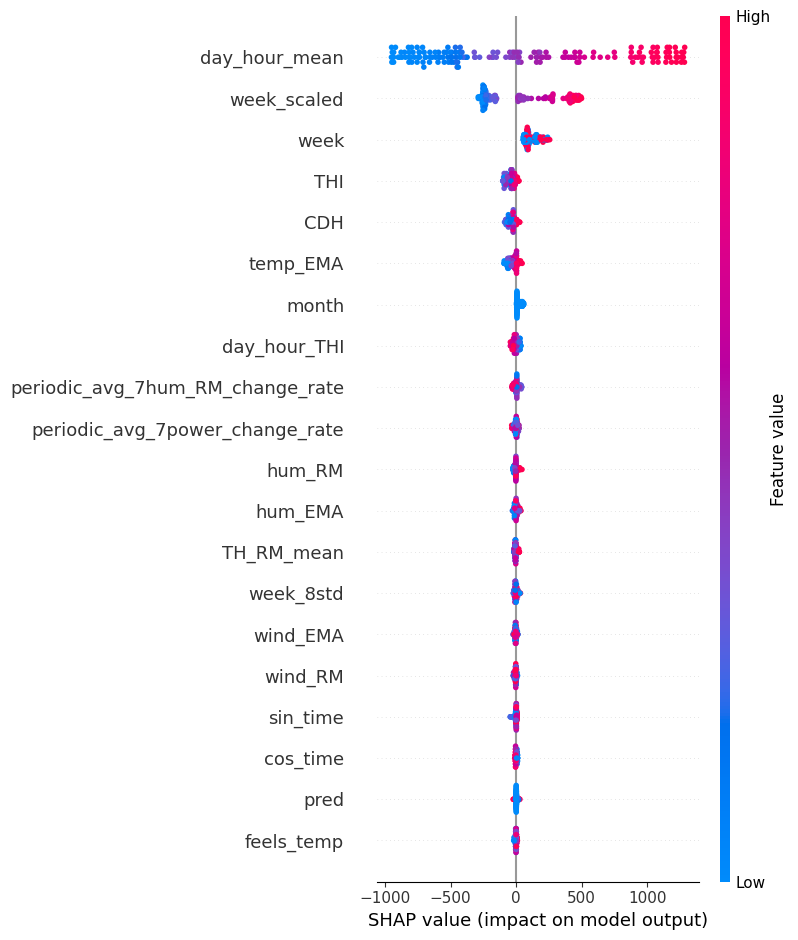

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

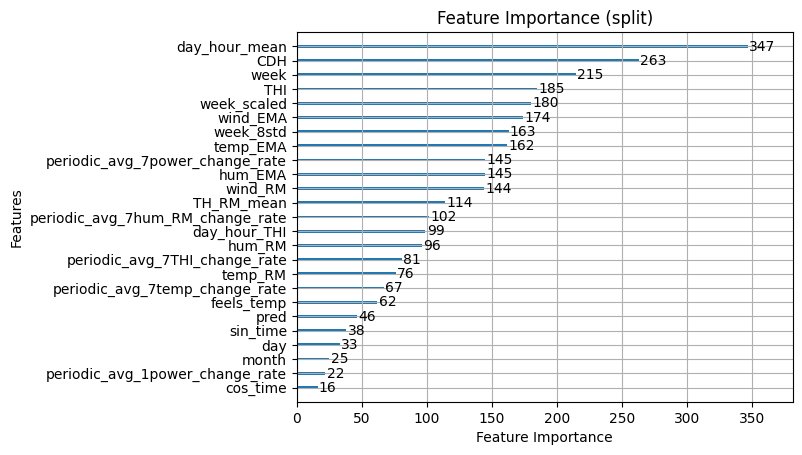

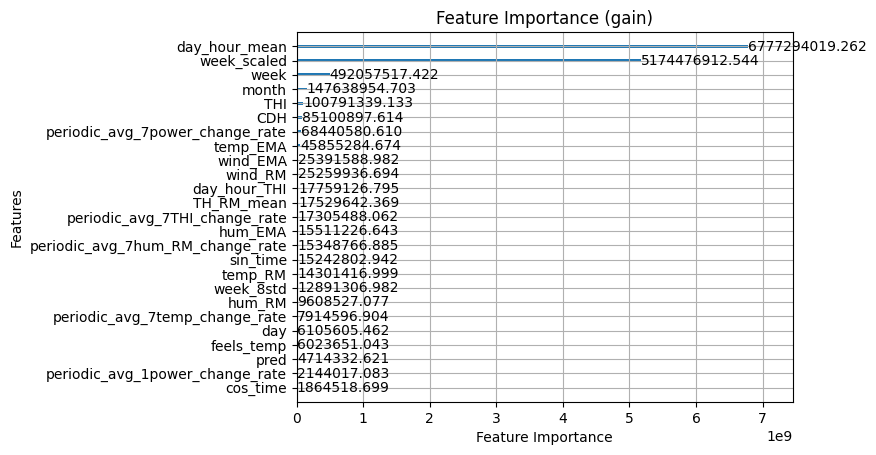

In [ ]:
# 보고싶은 building_num 입력하기
building_num = 1
num = building_num - 1

# for df in train_df_list:
features = train_df_list[num].columns[2:].tolist()
pretrained_model = model_list[num]
X_valid = x_valid_list[num]
Y_valid = y_valid_list[num]
test_X = test_x_list[num]

# Permutation Importance
perm = PermutationImportance(pretrained_model, random_state=42).fit(X_valid, Y_valid)
print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = features, top=10)))

# SHAP (shapely value)
shap.initjs()
explainer = shap.TreeExplainer(pretrained_model)
shap_values = explainer.shap_values(test_X)
fig = shap.summary_plot(shap_values, test_X)

# SPLIT
ax = lgb.plot_importance(pretrained_model, max_num_features=len(features), importance_type='split')
ax.set(title=f'Feature Importance (split)',
    xlabel='Feature Importance',
    ylabel='Features')

# GAIN
ax = lgb.plot_importance(pretrained_model, max_num_features=len(features), importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
    xlabel='Feature Importance',
    ylabel='Features')

## 피쳐 드랍

In [ ]:
# 1
selected_cols = ['day_hour_mean', 'week_scaled', 'week']  # 남겨둘 피쳐
drop_cols = train_df_1.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_1 = train_df_1.drop(columns=drop_cols)
test_df_1 = test_df_1.drop(columns=drop_cols)

# 2
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_2.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_2 = train_df_2.drop(columns=drop_cols)
test_df_2 = test_df_2.drop(columns=drop_cols)

# 3
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_3.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_3 = train_df_3.drop(columns=drop_cols)
test_df_3 = test_df_3.drop(columns=drop_cols)

# 4
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_4.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_4 = train_df_4.drop(columns=drop_cols)
test_df_4 = test_df_4.drop(columns=drop_cols)

# 5
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_5.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_5 = train_df_5.drop(columns=drop_cols)
test_df_5 = test_df_5.drop(columns=drop_cols)

# 6
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_6.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_6 = train_df_6.drop(columns=drop_cols)
test_df_6 = test_df_6.drop(columns=drop_cols)

# 7
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_7.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_7 = train_df_7.drop(columns=drop_cols)
test_df_7 = test_df_7.drop(columns=drop_cols)

# 8
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_8.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_8 = train_df_8.drop(columns=drop_cols)
test_df_8 = test_df_8.drop(columns=drop_cols)

# 9
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_9.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_9 = train_df_9.drop(columns=drop_cols)
test_df_9 = test_df_9.drop(columns=drop_cols)

# 10
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_10.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_10 = train_df_10.drop(columns=drop_cols)
test_df_10 = test_df_10.drop(columns=drop_cols)

# 11
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_11.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_11 = train_df_11.drop(columns=drop_cols)
test_df_11 = test_df_11.drop(columns=drop_cols)

# 12
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_12.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_12 = train_df_12.drop(columns=drop_cols)
test_df_12 = test_df_12.drop(columns=drop_cols)

# 13
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_13.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_13 = train_df_13.drop(columns=drop_cols)
test_df_13 = test_df_13.drop(columns=drop_cols)

# 14
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_14.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_14 = train_df_14.drop(columns=drop_cols)
test_df_14 = test_df_14.drop(columns=drop_cols)

# 15
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_15.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_15 = train_df_15.drop(columns=drop_cols)
test_df_15 = test_df_15.drop(columns=drop_cols)

# 16
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_16.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_16 = train_df_16.drop(columns=drop_cols)
test_df_16 = test_df_16.drop(columns=drop_cols)

# 17
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_17.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_17 = train_df_17.drop(columns=drop_cols)
test_df_17 = test_df_17.drop(columns=drop_cols)

# 18
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_18.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_18 = train_df_18.drop(columns=drop_cols)
test_df_18 = test_df_18.drop(columns=drop_cols)

# 19
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_19.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_19 = train_df_19.drop(columns=drop_cols)
test_df_19 = test_df_19.drop(columns=drop_cols)

# 20
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_20.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_20 = train_df_20.drop(columns=drop_cols)
test_df_20 = test_df_20.drop(columns=drop_cols)

# 21
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_21.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_21 = train_df_21.drop(columns=drop_cols)
test_df_21 = test_df_21.drop(columns=drop_cols)

# 22
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_22.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_22 = train_df_22.drop(columns=drop_cols)
test_df_22 = test_df_22.drop(columns=drop_cols)

# 23
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_23.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_23 = train_df_23.drop(columns=drop_cols)
test_df_23 = test_df_23.drop(columns=drop_cols)

# 24
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_24.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_24 = train_df_24.drop(columns=drop_cols)
test_df_24 = test_df_24.drop(columns=drop_cols)

# 25
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_25.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_25 = train_df_25.drop(columns=drop_cols)
test_df_25 = test_df_25.drop(columns=drop_cols)

# 26
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_26.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_26 = train_df_26.drop(columns=drop_cols)
test_df_26 = test_df_26.drop(columns=drop_cols)

# 27
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_27.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_27 = train_df_27.drop(columns=drop_cols)
test_df_27 = test_df_27.drop(columns=drop_cols)

# 28
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_28.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_28 = train_df_28.drop(columns=drop_cols)
test_df_28 = test_df_28.drop(columns=drop_cols)

# 29
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_29.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_29 = train_df_29.drop(columns=drop_cols)
test_df_29 = test_df_29.drop(columns=drop_cols)

# 30
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_30.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_30 = train_df_30.drop(columns=drop_cols)
test_df_30 = test_df_30.drop(columns=drop_cols)

# 31
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_31.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_31 = train_df_31.drop(columns=drop_cols)
test_df_31 = test_df_31.drop(columns=drop_cols)

# 32
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_32.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_32 = train_df_32.drop(columns=drop_cols)
test_df_32 = test_df_32.drop(columns=drop_cols)

# 33
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_33.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_33 = train_df_33.drop(columns=drop_cols)
test_df_33 = test_df_33.drop(columns=drop_cols)

# 34
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_34.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_34 = train_df_34.drop(columns=drop_cols)
test_df_34 = test_df_34.drop(columns=drop_cols)

# 35
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_35.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_35 = train_df_35.drop(columns=drop_cols)
test_df_35 = test_df_35.drop(columns=drop_cols)

# 36
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_36.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_36 = train_df_36.drop(columns=drop_cols)
test_df_36 = test_df_36.drop(columns=drop_cols)

# 37
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_37.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_37 = train_df_37.drop(columns=drop_cols)
test_df_37 = test_df_37.drop(columns=drop_cols)

# 38
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_38.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_38 = train_df_38.drop(columns=drop_cols)
test_df_38 = test_df_38.drop(columns=drop_cols)

# 39
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_39.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_39 = train_df_39.drop(columns=drop_cols)
test_df_39 = test_df_39.drop(columns=drop_cols)

# 40
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_40.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_40 = train_df_40.drop(columns=drop_cols)
test_df_40 = test_df_40.drop(columns=drop_cols)

# 41
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_41.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_41 = train_df_41.drop(columns=drop_cols)
test_df_41 = test_df_41.drop(columns=drop_cols)

# 42
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_42.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_42 = train_df_42.drop(columns=drop_cols)
test_df_42 = test_df_42.drop(columns=drop_cols)

# 43
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_43.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_43 = train_df_43.drop(columns=drop_cols)
test_df_43 = test_df_43.drop(columns=drop_cols)

# 44
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_44.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_44 = train_df_44.drop(columns=drop_cols)
test_df_44 = test_df_44.drop(columns=drop_cols)

# 45
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_45.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_45 = train_df_45.drop(columns=drop_cols)
test_df_45 = test_df_45.drop(columns=drop_cols)

# 46
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_46.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_46 = train_df_46.drop(columns=drop_cols)
test_df_46 = test_df_46.drop(columns=drop_cols)

# 47
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_47.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_47 = train_df_47.drop(columns=drop_cols)
test_df_47 = test_df_47.drop(columns=drop_cols)

# 48
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_48.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_48 = train_df_48.drop(columns=drop_cols)
test_df_48 = test_df_48.drop(columns=drop_cols)

# 49
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_49.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_49 = train_df_49.drop(columns=drop_cols)
test_df_49 = test_df_49.drop(columns=drop_cols)

# 50
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_50.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_50 = train_df_50.drop(columns=drop_cols)
test_df_50 = test_df_50.drop(columns=drop_cols)

# 51
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_51.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_51 = train_df_51.drop(columns=drop_cols)
test_df_51 = test_df_51.drop(columns=drop_cols)

# 52
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_52.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_52 = train_df_52.drop(columns=drop_cols)
test_df_52 = test_df_52.drop(columns=drop_cols)

# 53
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_53.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_53 = train_df_53.drop(columns=drop_cols)
test_df_53 = test_df_53.drop(columns=drop_cols)

# 54
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_54.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_54 = train_df_54.drop(columns=drop_cols)
test_df_54 = test_df_54.drop(columns=drop_cols)

# 55
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_55.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_55 = train_df_55.drop(columns=drop_cols)
test_df_55 = test_df_55.drop(columns=drop_cols)

# 56
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_56.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_56 = train_df_56.drop(columns=drop_cols)
test_df_56 = test_df_56.drop(columns=drop_cols)

# 57
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_57.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_57 = train_df_57.drop(columns=drop_cols)
test_df_57 = test_df_57.drop(columns=drop_cols)

# 58
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_58.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_58 = train_df_58.drop(columns=drop_cols)
test_df_58 = test_df_58.drop(columns=drop_cols)

# 59
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_59.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_59 = train_df_59.drop(columns=drop_cols)
test_df_59 = test_df_59.drop(columns=drop_cols)

# 60
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_60.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_60 = train_df_60.drop(columns=drop_cols)
test_df_60 = test_df_60.drop(columns=drop_cols)

# 61
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_61.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_61 = train_df_61.drop(columns=drop_cols)
test_df_61 = test_df_61.drop(columns=drop_cols)

# 62
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_62.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_62 = train_df_62.drop(columns=drop_cols)
test_df_62 = test_df_62.drop(columns=drop_cols)

# 63
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_63.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_63 = train_df_63.drop(columns=drop_cols)
test_df_63 = test_df_63.drop(columns=drop_cols)

# 64
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_64.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_64 = train_df_64.drop(columns=drop_cols)
test_df_64 = test_df_64.drop(columns=drop_cols)

# 65
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_65.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_65 = train_df_65.drop(columns=drop_cols)
test_df_65 = test_df_65.drop(columns=drop_cols)

# 66
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_66.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_66 = train_df_66.drop(columns=drop_cols)
test_df_66 = test_df_66.drop(columns=drop_cols)

# 67
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_67.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_67 = train_df_67.drop(columns=drop_cols)
test_df_67 = test_df_67.drop(columns=drop_cols)

# 68
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_68.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_68 = train_df_68.drop(columns=drop_cols)
test_df_68 = test_df_68.drop(columns=drop_cols)

# 69
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_69.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_69 = train_df_69.drop(columns=drop_cols)
test_df_69 = test_df_69.drop(columns=drop_cols)

# 70
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_70.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_70 = train_df_70.drop(columns=drop_cols)
test_df_70 = test_df_70.drop(columns=drop_cols)

# 71
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_71.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_71 = train_df_71.drop(columns=drop_cols)
test_df_71 = test_df_71.drop(columns=drop_cols)

# 72
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_72.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_72 = train_df_72.drop(columns=drop_cols)
test_df_72 = test_df_72.drop(columns=drop_cols)

# 73
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_73.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_73 = train_df_73.drop(columns=drop_cols)
test_df_73 = test_df_73.drop(columns=drop_cols)

# 74
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_74.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_74 = train_df_74.drop(columns=drop_cols)
test_df_74 = test_df_74.drop(columns=drop_cols)

# 75
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_75.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_75 = train_df_75.drop(columns=drop_cols)
test_df_75 = test_df_75.drop(columns=drop_cols)

# 76
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_76.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_76 = train_df_76.drop(columns=drop_cols)
test_df_76 = test_df_76.drop(columns=drop_cols)

# 77
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_77.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_77 = train_df_77.drop(columns=drop_cols)
test_df_77 = test_df_77.drop(columns=drop_cols)

# 78
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_78.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_78 = train_df_78.drop(columns=drop_cols)
test_df_78 = test_df_78.drop(columns=drop_cols)

# 79
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_79.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_79 = train_df_79.drop(columns=drop_cols)
test_df_79 = test_df_79.drop(columns=drop_cols)

# 80
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_80.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_80 = train_df_80.drop(columns=drop_cols)
test_df_80 = test_df_80.drop(columns=drop_cols)

# 81
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_81.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_81 = train_df_81.drop(columns=drop_cols)
test_df_81 = test_df_81.drop(columns=drop_cols)

# 82
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_82.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_82 = train_df_82.drop(columns=drop_cols)
test_df_82 = test_df_82.drop(columns=drop_cols)

# 83
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_83.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_83 = train_df_83.drop(columns=drop_cols)
test_df_83 = test_df_83.drop(columns=drop_cols)

# 84
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_84.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_84 = train_df_84.drop(columns=drop_cols)
test_df_84 = test_df_84.drop(columns=drop_cols)

# 85
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_85.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_85 = train_df_85.drop(columns=drop_cols)
test_df_85 = test_df_85.drop(columns=drop_cols)

# 86
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_86.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_86 = train_df_86.drop(columns=drop_cols)
test_df_86 = test_df_86.drop(columns=drop_cols)

# 87
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_87.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_87 = train_df_87.drop(columns=drop_cols)
test_df_87 = test_df_87.drop(columns=drop_cols)

# 88
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_88.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_88 = train_df_88.drop(columns=drop_cols)
test_df_88 = test_df_88.drop(columns=drop_cols)

# 89
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_89.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_89 = train_df_89.drop(columns=drop_cols)
test_df_89 = test_df_89.drop(columns=drop_cols)

# 90
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_90.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_90 = train_df_90.drop(columns=drop_cols)
test_df_90 = test_df_90.drop(columns=drop_cols)

# 91
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_91.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_91 = train_df_91.drop(columns=drop_cols)
test_df_91 = test_df_91.drop(columns=drop_cols)

# 92
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_92.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_92 = train_df_92.drop(columns=drop_cols)
test_df_92 = test_df_92.drop(columns=drop_cols)

# 93
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_93.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_93 = train_df_93.drop(columns=drop_cols)
test_df_93 = test_df_93.drop(columns=drop_cols)

# 94
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_94.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_94 = train_df_94.drop(columns=drop_cols)
test_df_94 = test_df_94.drop(columns=drop_cols)

# 95
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_95.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_95 = train_df_95.drop(columns=drop_cols)
test_df_95 = test_df_95.drop(columns=drop_cols)

# 96
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_96.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_96 = train_df_96.drop(columns=drop_cols)
test_df_96 = test_df_96.drop(columns=drop_cols)

# 97
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_97.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_97 = train_df_97.drop(columns=drop_cols)
test_df_97 = test_df_97.drop(columns=drop_cols)

# 98
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_98.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_98 = train_df_98.drop(columns=drop_cols)
test_df_98 = test_df_98.drop(columns=drop_cols)

# 99
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_99.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_99 = train_df_99.drop(columns=drop_cols)
test_df_99 = test_df_99.drop(columns=drop_cols)

# 100
selected_cols = []  # 남겨둘 피쳐
drop_cols = train_df_100.columns[2:].tolist()
drop_cols = [col for col in drop_cols if col not in selected_cols]
train_df_100 = train_df_100.drop(columns=drop_cols)
test_df_100 = test_df_100.drop(columns=drop_cols)

# 건물별 예측(2차, 4 Fold)

In [ ]:
# LGBM 모델 사용
lgbm_preds = np.array([])
fold = 4
smape_score_mean = []
for train_df, test_df in zip(train_list, test_list):
    model = LGBMRegressor(random_state=SEED, objective='regression')
    train_x, train_y, test_x = make_dataset(eval(train_df), eval(test_df))
    # 건물별 fold별 smape score
    smape_score = []
    for n in range(fold):
        x_train, y_train, x_valid, y_valid = n_fold_train_test_split(train_x, train_y, n=n)
        model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], callbacks = [early_stopping(300)], eval_metric=lightgbm_smape)
        pred = model.predict(x_valid)
        score = _smape(y_valid, pred)
        smape_score.append(score)
    smape_score_mean.append(np.mean(smape_score))

    lgbm_pred = lgbm_test_predict(model, train_x, train_y, test_x)
    lgbm_preds = np.concatenate([lgbm_preds, lgbm_pred])

print(smape_score_mean)

In [ ]:
lgbm_preds.shape

(16800,)

In [ ]:
# XGBoost 모델 사용
xgb_preds = np.array([])
fold = 4
smape_score_mean = []
for train_df, test_df in tqdm(zip(train_list, test_list), total=100):
    model = XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0)
    train_x, train_y, test_x = make_dataset(eval(train_df), eval(test_df))
    # 건물별 fold별 smape score
    smape_score = []
    for n in tqdm(range(fold)):
        x_train, y_train, x_valid, y_valid = n_fold_train_test_split(train_x, train_y, n=n)

        model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], early_stopping_rounds=60, eval_metric=xgb_smape)

        pred = model.predict(x_valid)
        score = _smape(y_valid, pred)
        smape_score.append(score)

    smape_score_mean.append(np.mean(smape_score))

    xgb_pred = xgb_test_predict(model, train_x, train_y, test_x)
    xgb_preds = np.concatenate([xgb_preds, xgb_pred])

print(smape_score_mean)

In [ ]:
np.mean(smape_score_mean)

2.705632736860175

In [ ]:
xgb_preds.shape

(16800,)

## 예측값 저장

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [ ]:
submission.shape

(16800, 2)

In [ ]:
# submission['answer']= lgbm_preds

In [ ]:
# submission.to_csv(f"{DATA_PATH}LGBM_submission_ver4_nsw.csv", index=False)

In [ ]:
submission['answer'] = xgb_preds

In [ ]:
submission.isnull().sum()

num_date_time    0
answer           0
dtype: int64

In [ ]:
submission.to_csv(f"{DATA_PATH}XGB_submission_ver6_nsw.csv", index=False)

- TWH 관련 피쳐와 전력 관련 피쳐 앙상블

In [ ]:
# ver5_22 = pd.read_csv(f"{DATA_PATH}XGB_submission_ver5_22_nsw.csv")
# ver5_23 = pd.read_csv(f"{DATA_PATH}XGB_submission_ver5_23_nsw.csv")

In [ ]:
# (ver5_22 + ver5_23)/2

In [ ]:
# submission['answer'] = (ver5_22 + ver5_23)/2

In [ ]:
# submission.isnull().sum()

In [ ]:
# submission.to_csv(f"{DATA_PATH}XGB_submission_ver5_ensemble_nsw.csv", index=False)